# This is the notebook for QCing the data

## Use sc_gpu/rapids_sc/scv environment for this part

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rapids_singlecell as rsc
import scvi

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [3]:
import logging
#reduce logging amount
# Configure logging
logging.basicConfig(level=logging.WARNING)

In [18]:
input_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/data/velocyto_cellbender_processed/before_qc/combined_raw/"

In [19]:
# Process all screens
samples = [f'screen-{i}' for i in range(1, 5)]

In [20]:
adata_list = []
for sample in samples:
    #check which sample we're using
    print(f'merging {sample}' )
    # read in object
    adata = sc.read_h5ad(input_dir + sample + '_combined.h5ad')
    adata_list.append(adata)

merging screen-1


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-2


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-3


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-4


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [21]:
adata_list

[AnnData object with n_obs × n_vars = 16041 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 21092 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
     var: 'ambient_exp

In [22]:
aav = ['AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10']
for adata in adata_list:
    print(sum(adata.var_names.isin(aav)))

4
4
4
4


# Preprocessing: Initial Filtration and Doublet Removal

## Basic Filtering

In [23]:
# filter out useless genes
for adata in adata_list:
    adata.var_names_make_unique
    sc.pp.filter_genes(adata, min_cells= 1)
    sc.pp.filter_cells(adata,min_genes = 200)

filtered out 28457 genes that are detected in less than 1 cells
filtered out 5097 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28397 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 8587 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28710 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 6488 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28757 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 4799 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
for adata in adata_list:
    print(sum(adata.var_names.isin(aav)))

4
4
4
4


In [25]:
#check for dupes
[adata.var_names for adata in adata_list]

[Index(['Xkr4', 'Gm18956', 'Gm37180', 'Gm37363', 'Gm1992', 'Gm7341', 'Gm38148',
        'Gm19938', 'Gm10568', 'Rp1',
        ...
        'mt-Nd6', 'mt-Cytb', 'mt-Tp', 'ENSMUSG00000079190',
        'ENSMUSG00000079808', 'ENSMUSG00000095041', 'AAV1', 'AAV7', 'AAVDJ8',
        'AAVRH10'],
       dtype='object', name='gene_name', length=28727),
 Index(['Xkr4', 'Gm18956', 'Gm37180', 'Gm37363', 'Gm1992', 'Gm7341', 'Gm38148',
        'Gm19938', 'Gm10568', 'Gm37381',
        ...
        'mt-Tp', 'ENSMUSG00000079800', 'ENSMUSG00000079192',
        'ENSMUSG00000079190', 'ENSMUSG00000079808', 'ENSMUSG00000095041',
        'AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10'],
       dtype='object', name='gene_name', length=28787),
 Index(['Xkr4', 'Gm18956', 'Gm37180', 'Gm37363', 'Gm1992', 'Gm37329', 'Gm7341',
        'Gm38148', 'Gm19938', 'Gm10568',
        ...
        'mt-Nd6', 'mt-Cytb', 'mt-Tp', 'ENSMUSG00000079190',
        'ENSMUSG00000079808', 'ENSMUSG00000095041', 'AAV1', 'AAV7', 'AAVDJ8',
        'AAVRH10

### We will use the scvi SOLO package. For this package, we will accelerate the doublet removal process using a GPU and we will shorten down our matrix by finding the highly variable genes. To clarify, we will only be using the RAW counts

In [26]:
def find_doublets(adata):
    sc.pp.highly_variable_genes(adata,
                                n_top_genes = 3000,
                                subset = True,
                                flavor = 'seurat_v3'
                                )
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train(accelerator = 'gpu',
              log_every_n_steps = 250)
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train(accelerator = 'gpu')
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    print(df)
    print(df.groupby('prediction').count())
    return df

In [27]:
adata_list

[AnnData object with n_obs × n_vars = 10944 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 12505 × 28787
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch',

In [28]:
adata_list_predoubs = adata_list.copy()

In [29]:
adata_list_predoubs

[AnnData object with n_obs × n_vars = 10944 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 12505 × 28787
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch',

In [30]:
df_list = []
for adata in adata_list_predoubs:
    df = find_doublets(adata)
    df_list.append(df)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` wh

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [05:40<00:00,  1.14it/s, v_num=1, train_loss_step=287, train_loss_epoch=290]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:40<00:00,  1.17it/s, v_num=1, train_loss_step=287, train_loss_epoch=290]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 202/400:  50%|█████     | 202/400 [02:03<02:01,  1.63it/s, v_num=1, train_loss_step=0.37, train_loss_epoch=0.361] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.368. Signaling Trainer to stop.
                   doublet   singlet prediction
CCTCTCCCCCTCCAAC  0.379809 -1.027779    doublet
AAGCGAGTCAAAGTTG  1.702747 -1.496212    doublet
CAGCCAGATCAACATA  0.637730 -0.665705    doublet
GATTTGTACAAAGAAT  0.995299 -1.022290    doublet
ATAGGCTTCAACGCTG  0.906714 -1.025773    doublet
...                    ...       ...        ...
GGTAACAGTTTCAGAA  0.539806 -0.268434    doublet
GGATGTTCATGTGAAC -0.064031  0.358608    singlet
CGGGACTGACCACAAA -0.795131  0.943704    singlet
CGGGACTGTAGGACCA -0.462785  1.035895    singlet
ACTATGGCTTCAAAGG -0.345904  0.788530    singlet

[10944 rows x 3 columns]
            doublet  singlet
prediction                  
doublet        3247     3247
singlet        7697     7697
extracting highly variable genes
--> added

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (88) is smaller than the logging interval Trainer(log_every_n_steps=250). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:19<00:00,  1.03it/s, v_num=1, train_loss_step=261, train_loss_epoch=259]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:19<00:00,  1.05it/s, v_num=1, train_loss_step=261, train_loss_epoch=259]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 358/400:  90%|████████▉ | 358/400 [03:38<00:25,  1.64it/s, v_num=1, train_loss_step=0.444, train_loss_epoch=0.361]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.352. Signaling Trainer to stop.
                   doublet   singlet prediction
AAGCATCTCTGTACTC  1.166954 -0.839297    doublet
CACGGGTCTTAAACTT  0.460522  0.007478    doublet
CATCCGTTCGCGGACT  1.876651 -1.063541    doublet
GACAGCCAGGGTCCAC  1.388626 -1.231690    doublet
GAGCATAGGAAACGAG  1.472745 -1.126382    doublet
...                    ...       ...        ...
CACTGGGATGTGCGAG -2.149974  2.053302    singlet
GCCTTTAGAAGGTGCA -2.852032  4.465605    singlet
GATTGGTGTCGGTACG -4.771848  6.467560    singlet
ACCTGTCGTTTATTCA  0.487773 -0.175825    doublet
GAGCATCTCCCGGTAC -0.027266  0.305706    singlet

[12505 rows x 3 columns]
            doublet  singlet
prediction                  
doublet        3891     3891
singlet        8614     8614
extracting highly variable genes
--> added

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (77) is smaller than the logging interval Trainer(log_every_n_steps=250). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:41<00:00,  1.31it/s, v_num=1, train_loss_step=445, train_loss_epoch=297]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:41<00:00,  1.42it/s, v_num=1, train_loss_step=445, train_loss_epoch=297]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 333/400:  83%|████████▎ | 333/400 [03:10<00:38,  1.75it/s, v_num=1, train_loss_step=0.83, train_loss_epoch=0.385] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.388. Signaling Trainer to stop.
                   doublet   singlet prediction
ACCCTGATCTCTGAGA  1.011637 -1.282262    doublet
AGCGCTGGTTGACGGA  1.317332 -1.146529    doublet
ACCAAGACAATTGTGC  1.778929 -1.308571    doublet
GGCCTGAGGTACATAT  1.164503 -0.237042    doublet
AGTGACCAGAAGGCAG  1.119061 -1.207585    doublet
...                    ...       ...        ...
CAAGACTATTCTTTAA -0.431266  0.185175    singlet
CGTGATACATAGCTGT -0.462798  0.336438    singlet
GGCTGTGCCTCTGCCT -0.556126  0.903232    singlet
ACCATTTACGGGTTGA -0.492827  0.492127    singlet
GGCAGCCTCATCGACA -1.372614  0.838039    singlet

[10860 rows x 3 columns]
            doublet  singlet
prediction                  
doublet        3791     3791
singlet        7069     7069
extracting highly variable genes
--> added

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (73) is smaller than the logging interval Trainer(log_every_n_steps=250). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:09<00:00,  1.30it/s, v_num=1, train_loss_step=332, train_loss_epoch=291]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:09<00:00,  1.29it/s, v_num=1, train_loss_step=332, train_loss_epoch=291]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 349/400:  87%|████████▋ | 349/400 [03:12<00:28,  1.82it/s, v_num=1, train_loss_step=0.518, train_loss_epoch=0.377]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.362. Signaling Trainer to stop.
                   doublet   singlet prediction
CCCTTTCAGAATTGCA  0.010316 -1.035884    doublet
GGTTAAATCACATTGG  0.503975 -1.650521    doublet
CCCTTAGAGCGACTGA  1.259680 -1.697278    doublet
AACCTTTGACCTCCAA  0.999474 -1.717222    doublet
CGAATTGCCCAAAGTA -0.342956 -1.126745    doublet
...                    ...       ...        ...
CCGCAAGTCTCGGCTG -0.624894  0.260173    singlet
AGACACACAGTATTCG -1.671351  1.281610    singlet
AGACAATCAGCGCGTT -1.522607  1.062315    singlet
CGAATTGGTGGGCCTC -0.759249  0.619365    singlet
CATAGACTCCTAACAG -1.196043  0.860244    singlet

[10299 rows x 3 columns]
            doublet  singlet
prediction                  
doublet        3454     3454
singlet        6845     6845


In [31]:
[print(df.groupby('prediction').count()) for df in df_list]

            doublet  singlet
prediction                  
doublet        3247     3247
singlet        7697     7697
            doublet  singlet
prediction                  
doublet        3891     3891
singlet        8614     8614
            doublet  singlet
prediction                  
doublet        3791     3791
singlet        7069     7069
            doublet  singlet
prediction                  
doublet        3454     3454
singlet        6845     6845


[None, None, None, None]

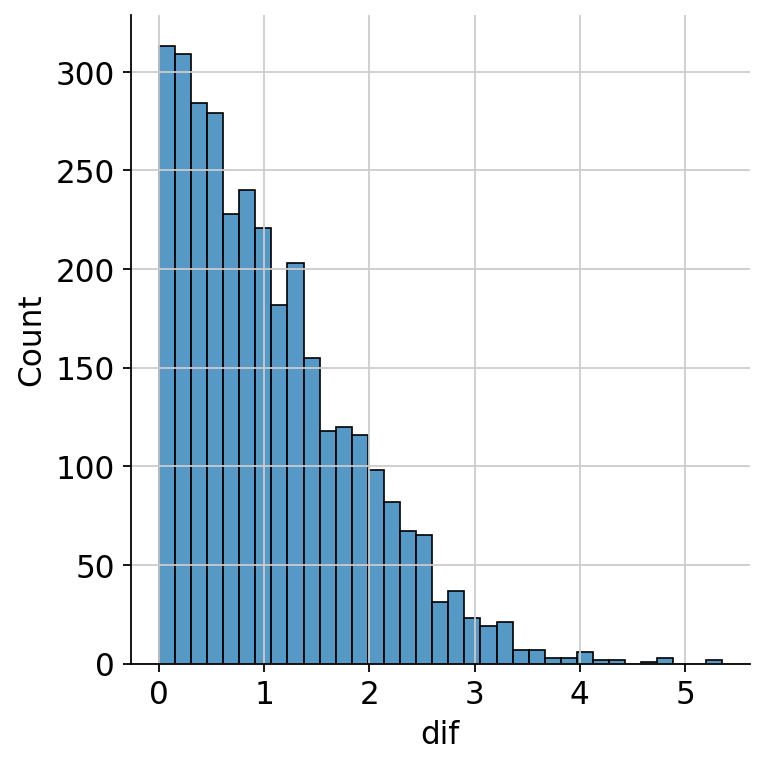

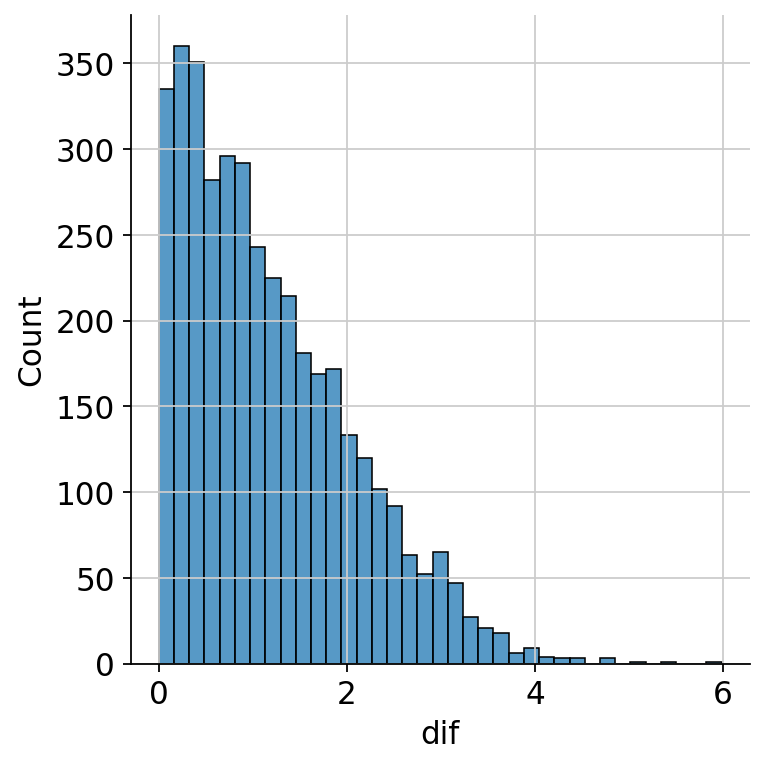

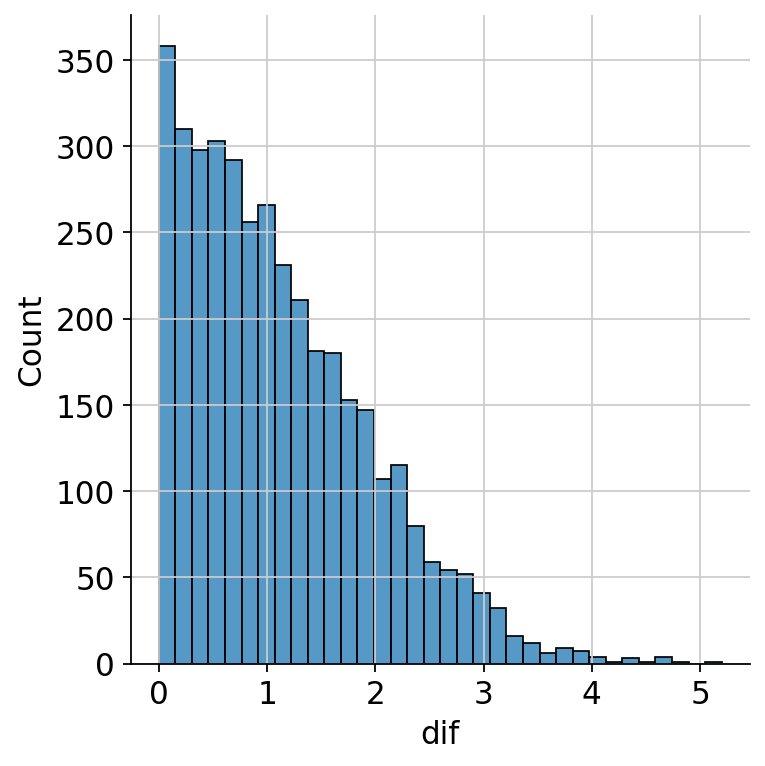

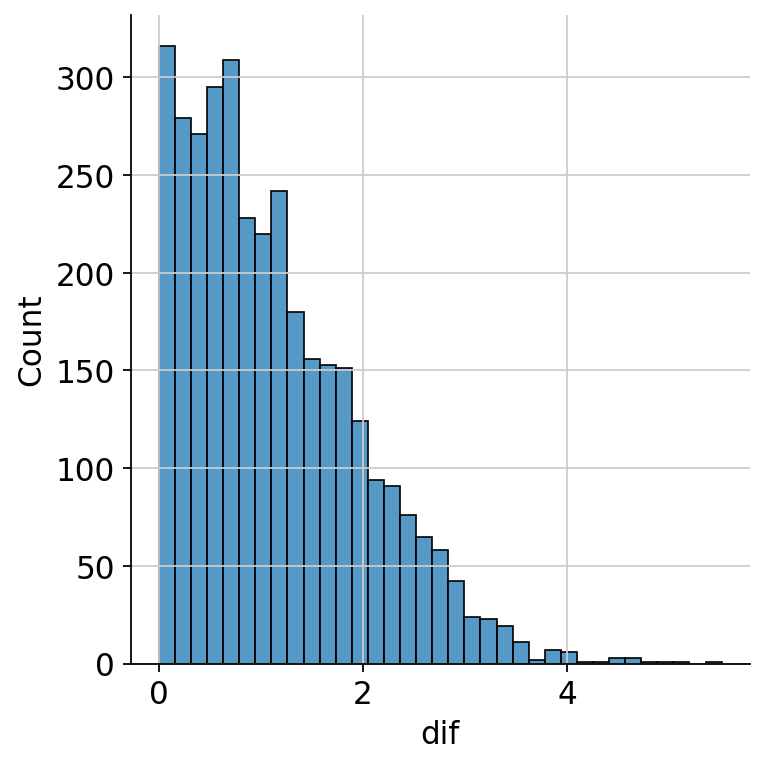

In [32]:
def calc_diff(df):
    df['dif'] = df.doublet - df.singlet
    
[calc_diff(df) for df in df_list]
import seaborn as sns
[sns.displot(df[df.prediction == 'doublet'], x = 'dif') for df in df_list]

In [33]:
doublet_list = []
def doublet_cutoff(df, cutoff = 1):
    doublet_score_cutoff = cutoff
    doublets = df[(df.prediction == 'doublet') & (df.dif > doublet_score_cutoff)]
    return doublets

[doublet_list.append(doublet_cutoff(df)) for df in df_list]

[None, None, None, None]

In [34]:
[print(doublet.shape) for doublet in doublet_list]
[print(df.shape) for df in df_list]

(1464, 4)
(1926, 4)
(1826, 4)
(1677, 4)
(10944, 4)
(12505, 4)
(10860, 4)
(10299, 4)


[None, None, None, None]

In [35]:
[doublet.index[1:10] for doublet in doublet_list]

[Index(['AAGCGAGTCAAAGTTG', 'CAGCCAGATCAACATA', 'GATTTGTACAAAGAAT',
        'ATAGGCTTCAACGCTG', 'AGAGAATGTTTCTTAC', 'GGGTTGTGTTCTCTCG',
        'GTCCTCAAGAGCAGTA', 'ACATCCCAATCCAAAA', 'CAATGACTCCTGCGTC'],
       dtype='object'),
 Index(['CATCCGTTCGCGGACT', 'GACAGCCAGGGTCCAC', 'GAGCATAGGAAACGAG',
        'CGTCCATAGAGTGAAT', 'GAACGTTGTGTATAAG', 'GGAATGGGTCCTACAA',
        'CGATGGCCAAAGTACG', 'CTCTGTTTTGTTGTCT', 'CGGAGAATCGGCTTAT'],
       dtype='object'),
 Index(['AGCGCTGGTTGACGGA', 'ACCAAGACAATTGTGC', 'GGCCTGAGGTACATAT',
        'AGTGACCAGAAGGCAG', 'CTTCCTTTCATCTTCA', 'AGCCAGCTATTGGCTC',
        'ACCTACCACCTGTGCC', 'GCCATTCTCCGTCTCA', 'GTCAACATCAAAAGTG'],
       dtype='object'),
 Index(['GGTTAAATCACATTGG', 'CCCTTAGAGCGACTGA', 'AACCTTTGACCTCCAA',
        'CTCCTTTGGTGCTCAT', 'CTCGAGGCAATTCTCC', 'AGTTCCCTTAGAAAGA',
        'CACAGGCCAAACGGCG', 'GGGACCTGTTCTTTCT', 'CTGTACCTCGTCGGGT'],
       dtype='object')]

In [40]:
del adata_list

In [42]:
adata_list = []
for sample in samples:
    #check which sample we're using
    print(f'merging {sample}' )
    # read in object
    adata = sc.read_h5ad(input_dir + sample + '_combined.h5ad')
    adata_list.append(adata)

merging screen-1


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-2


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-3


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


merging screen-4


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [43]:
# filter out useless genes
for adata in adata_list:
    adata.var_names_make_unique
    sc.pp.filter_genes(adata, min_cells= 1)
    sc.pp.filter_cells(adata,min_genes = 200)

filtered out 28457 genes that are detected in less than 1 cells
filtered out 5097 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28397 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 8587 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28710 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 6488 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 28757 genes that are detected in less than 1 cells


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 4799 cells that have less than 200 genes expressed


/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [44]:
adata_list

[AnnData object with n_obs × n_vars = 10944 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 12505 × 28787
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch',

In [50]:
adata_list_nodoub = []
for i,adata in enumerate(adata_list):
    adata.obs['doublet'] = adata.obs.index.isin(doublet_list[i].index)
    print(adata.obs['doublet'].value_counts())
    adata = adata[~adata.obs.doublet]
    adata_list_nodoub.append(adata)

doublet
False    9480
True     1464
Name: count, dtype: int64
doublet
False    10579
True      1926
Name: count, dtype: int64
doublet
False    9034
True     1826
Name: count, dtype: int64
doublet
False    8622
True     1677
Name: count, dtype: int64


In [51]:
adata_list_nodoub

[View of AnnData object with n_obs × n_vars = 9480 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'spliced', 'unspliced',
 View of AnnData object with n_obs × n_vars = 10579 × 28787
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'dro

In [52]:
aav

['AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10']

In [53]:
[sum(adata.var_names.isin(aav)) for adata in adata_list_nodoub]

[4, 4, 4, 4]

In [60]:
output_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/data/velocyto_cellbender_processed/before_qc/doublet_removal"
for i,adata in enumerate(adata_list_nodoub):
    adata.var_names_make_unique()
    adata.write(os.path.join(output_dir, samples[i]+'-nodoublets_combined.h5ad'))

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [61]:
def process_data(adata):
    #remove duplicate names first
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    # ribosomal genes    
    adata.var["ribo"] = adata.var_names.str.startswith("Rpl") | adata.var_names.str.startswith("Rps")
    # calculate qc metrics
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"],percent_top=[20], inplace=True, log1p=True)
    #print the violin plot of metrics
    print(sc.pl.violin(adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True,))
    print(sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt"))

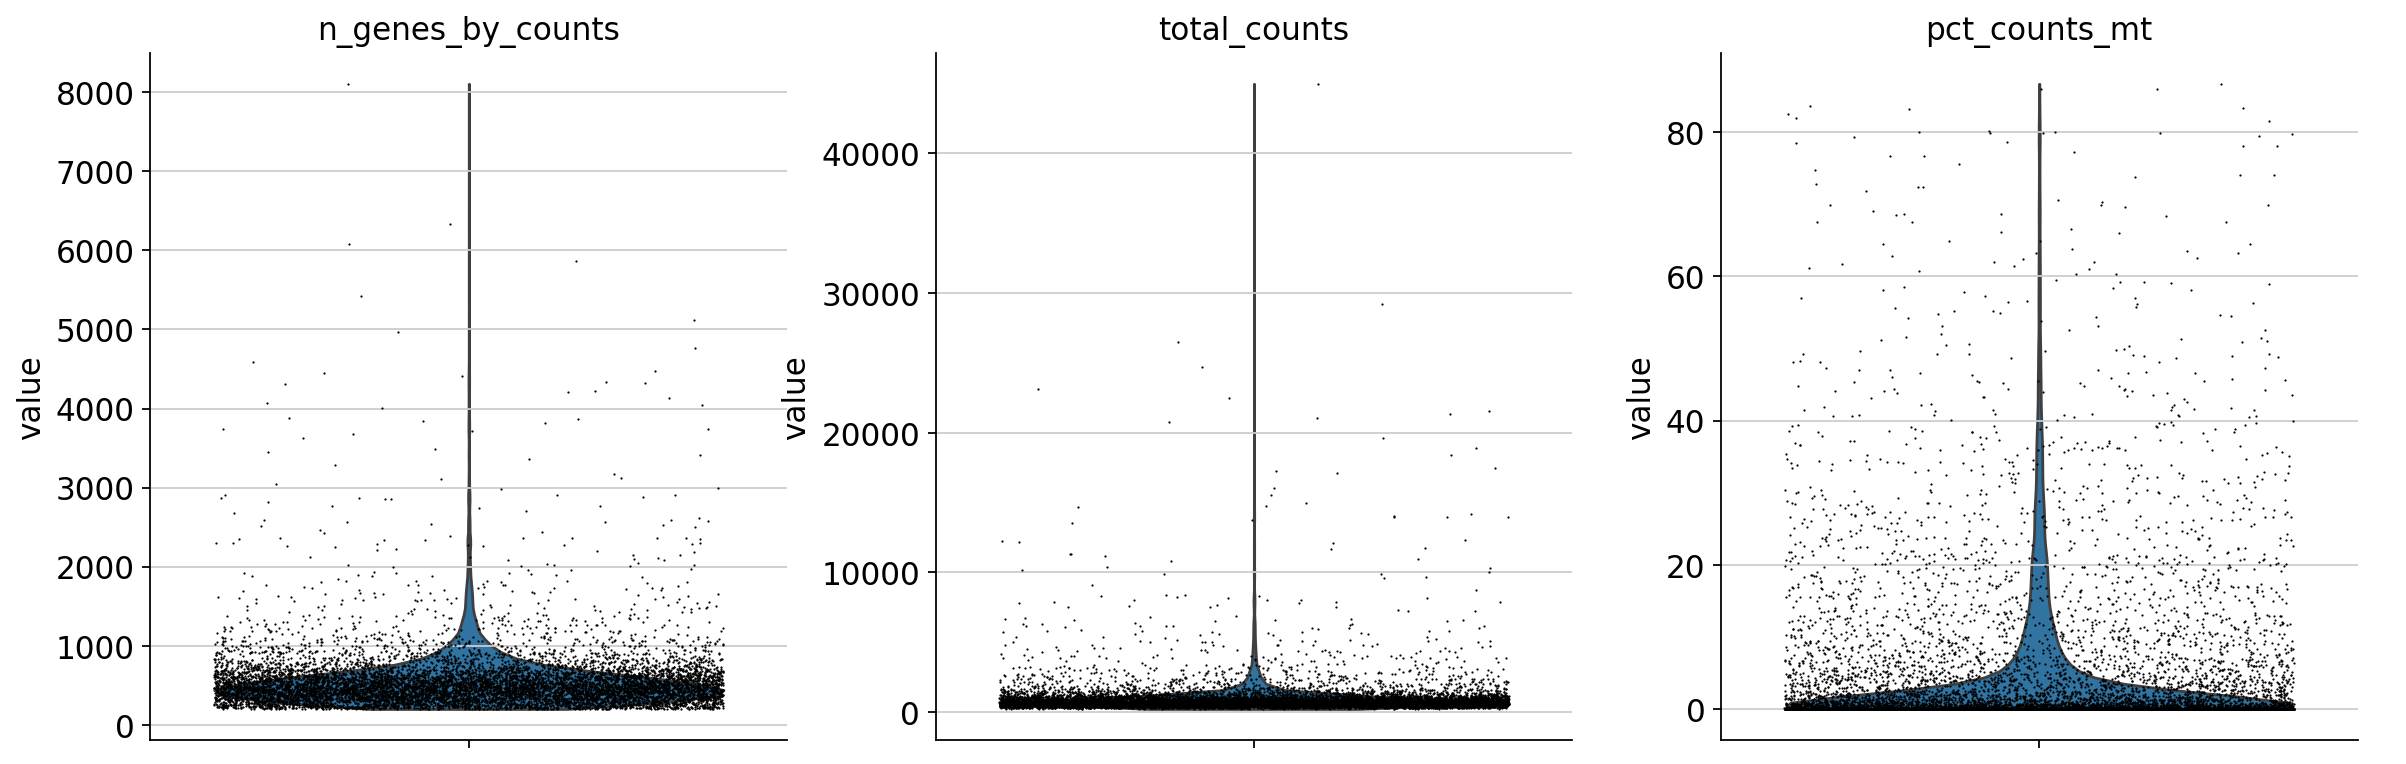

None


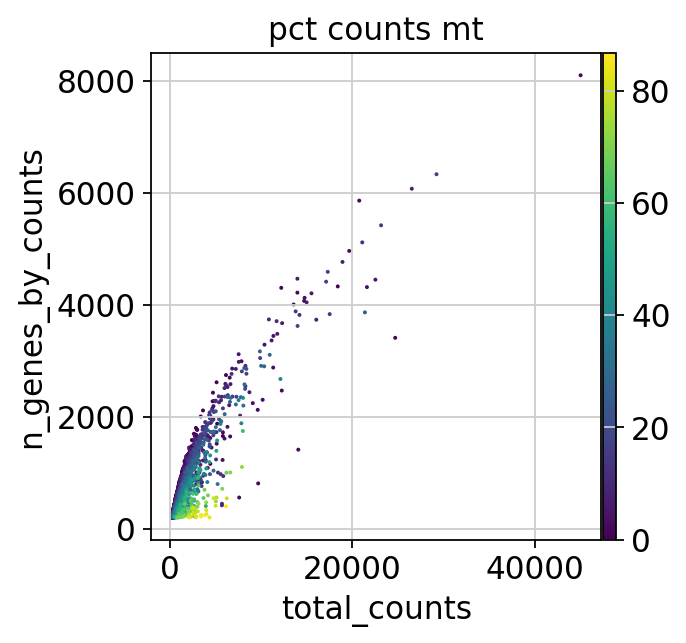

None


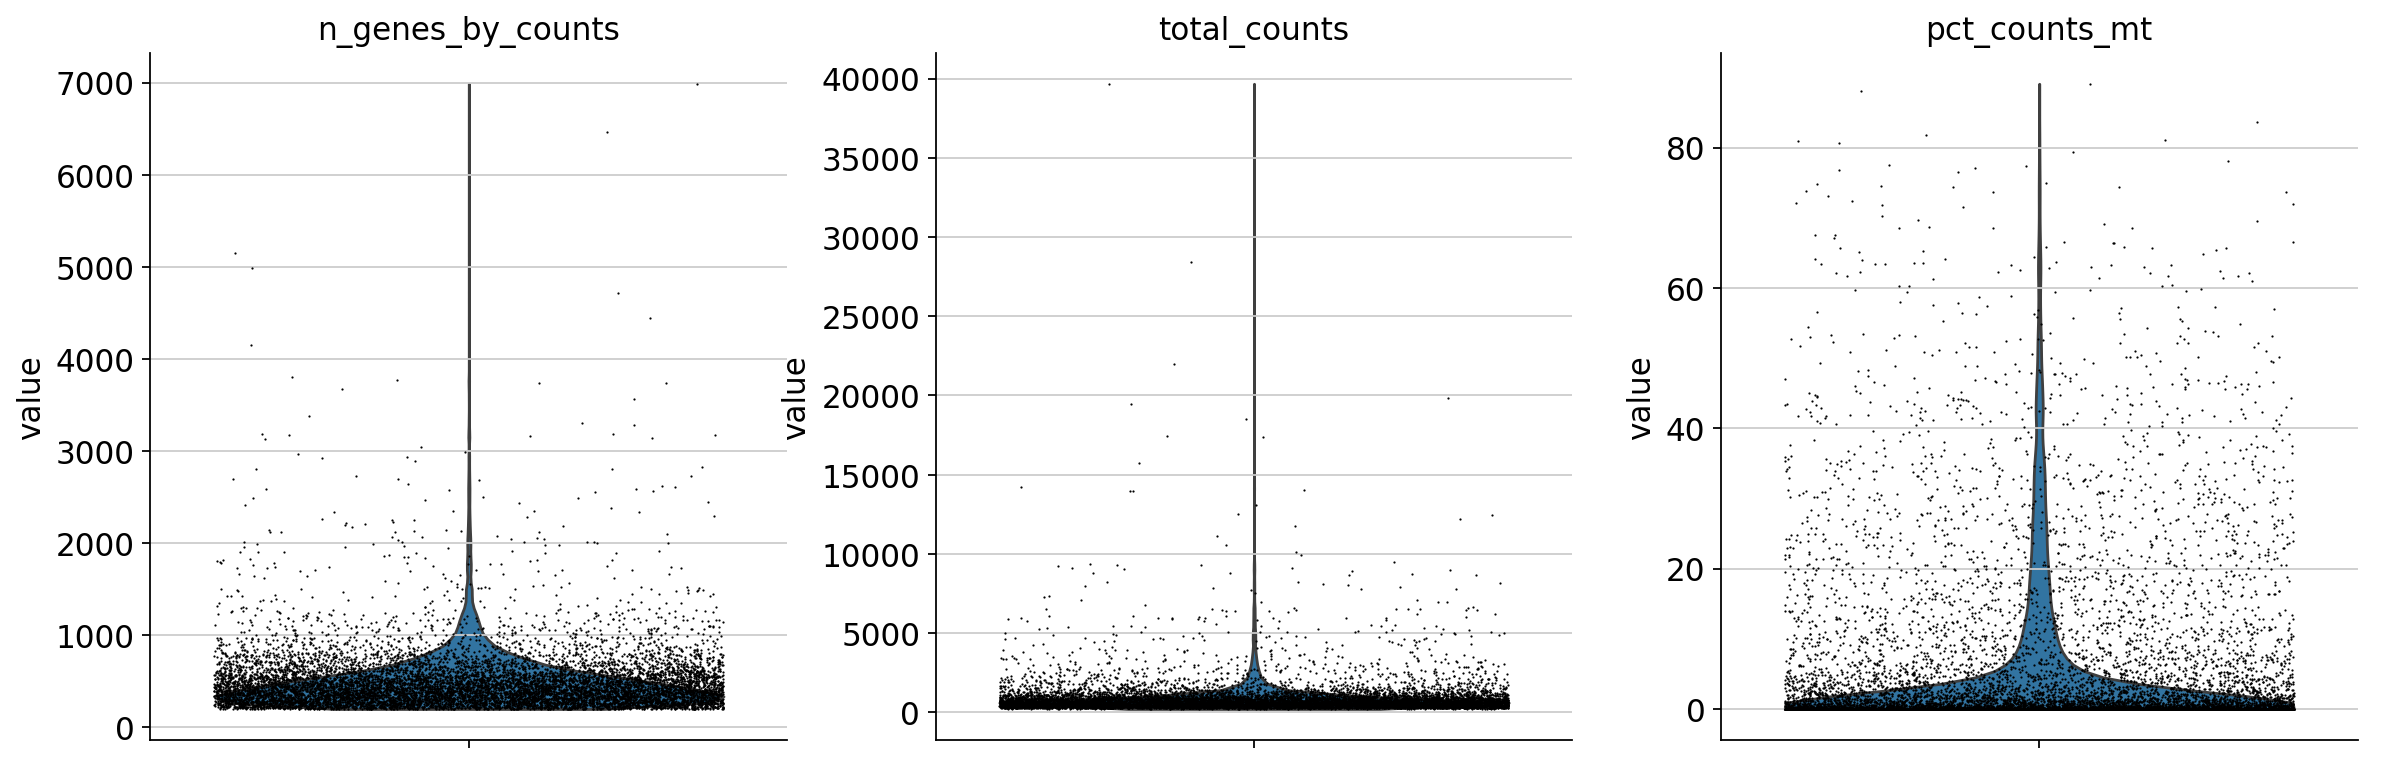

None


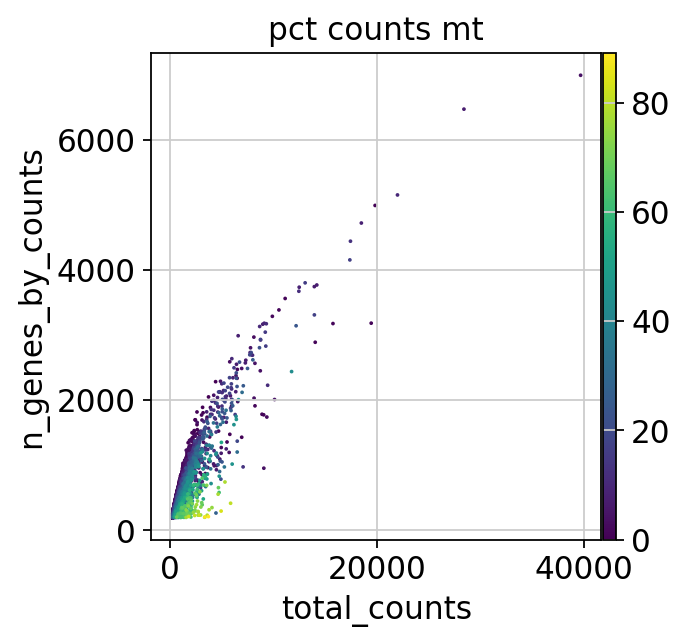

None


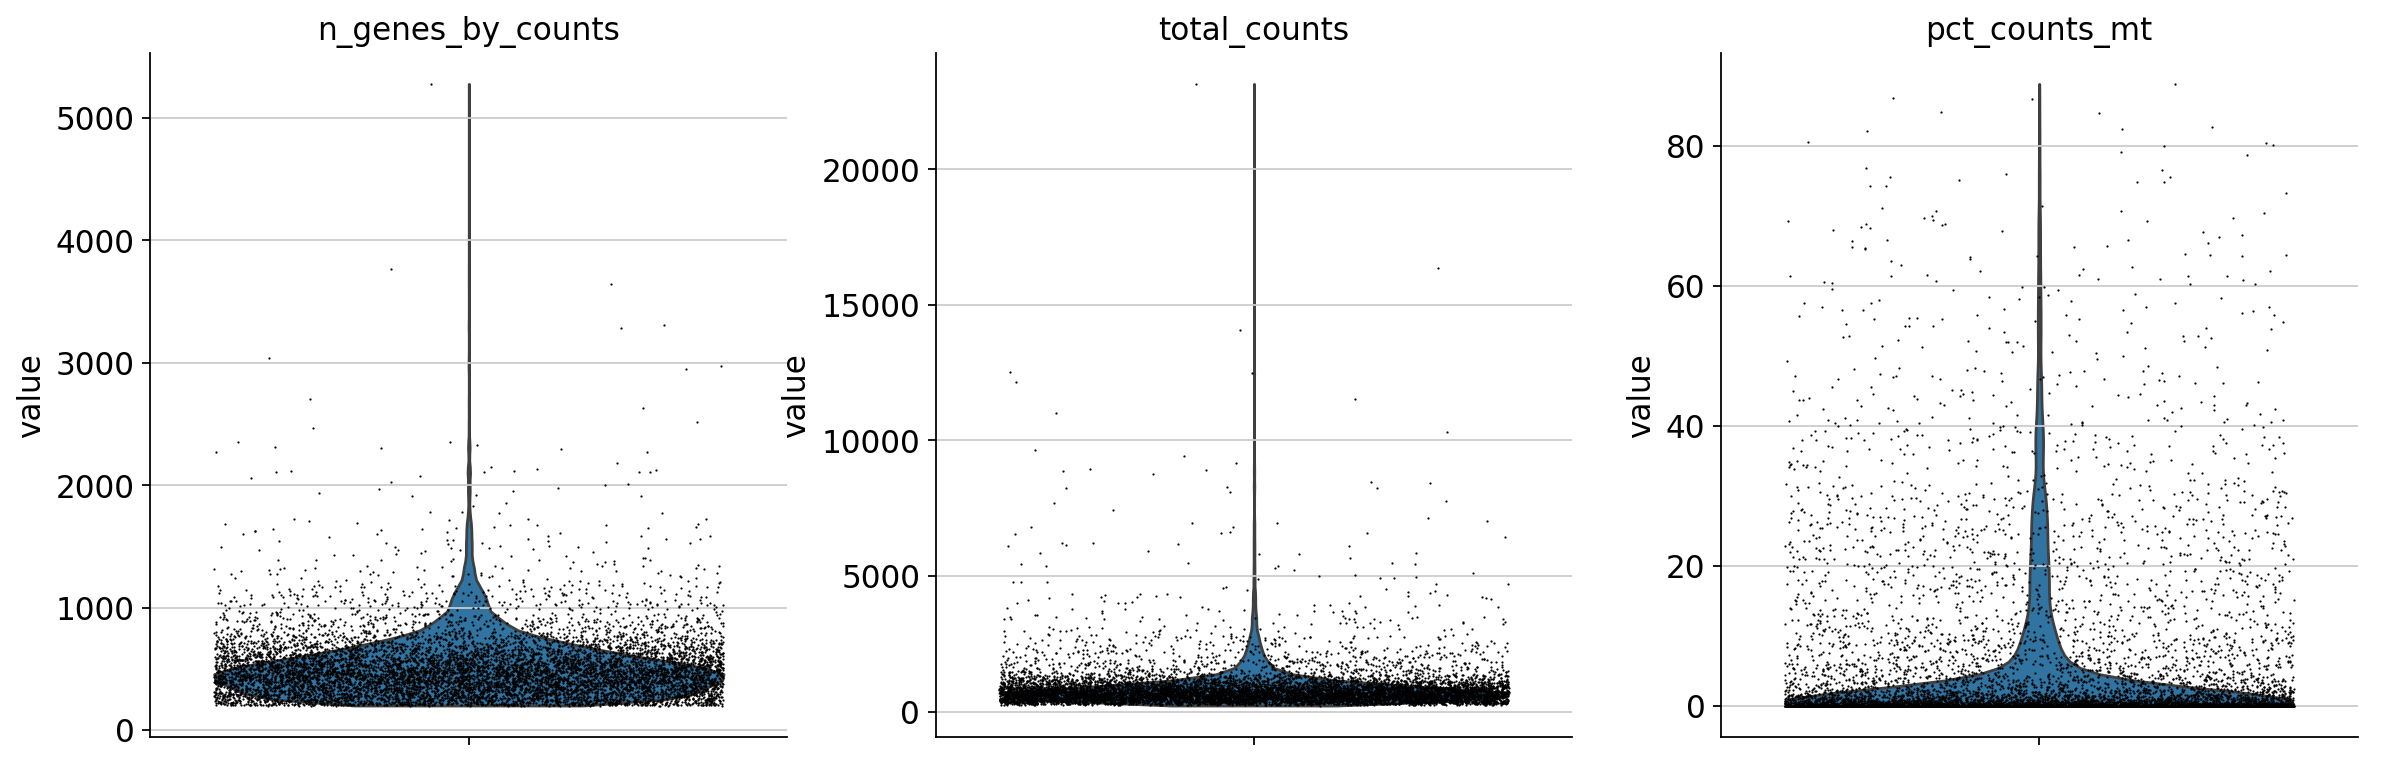

None


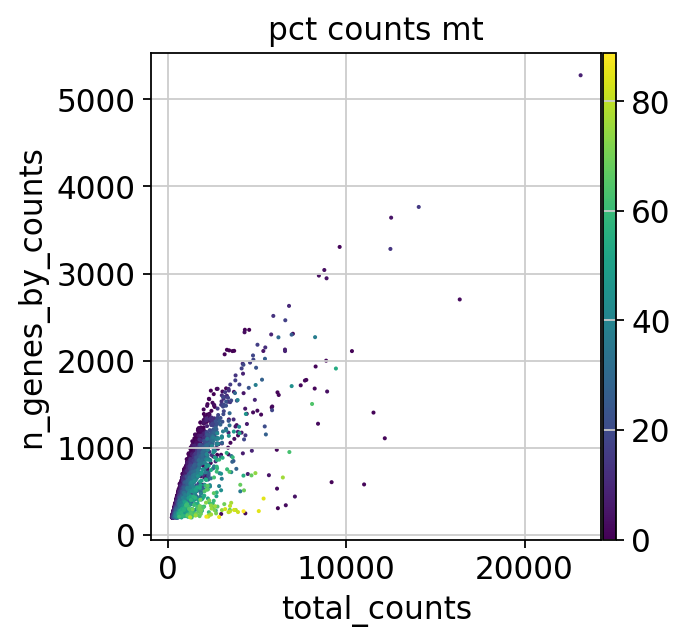

None


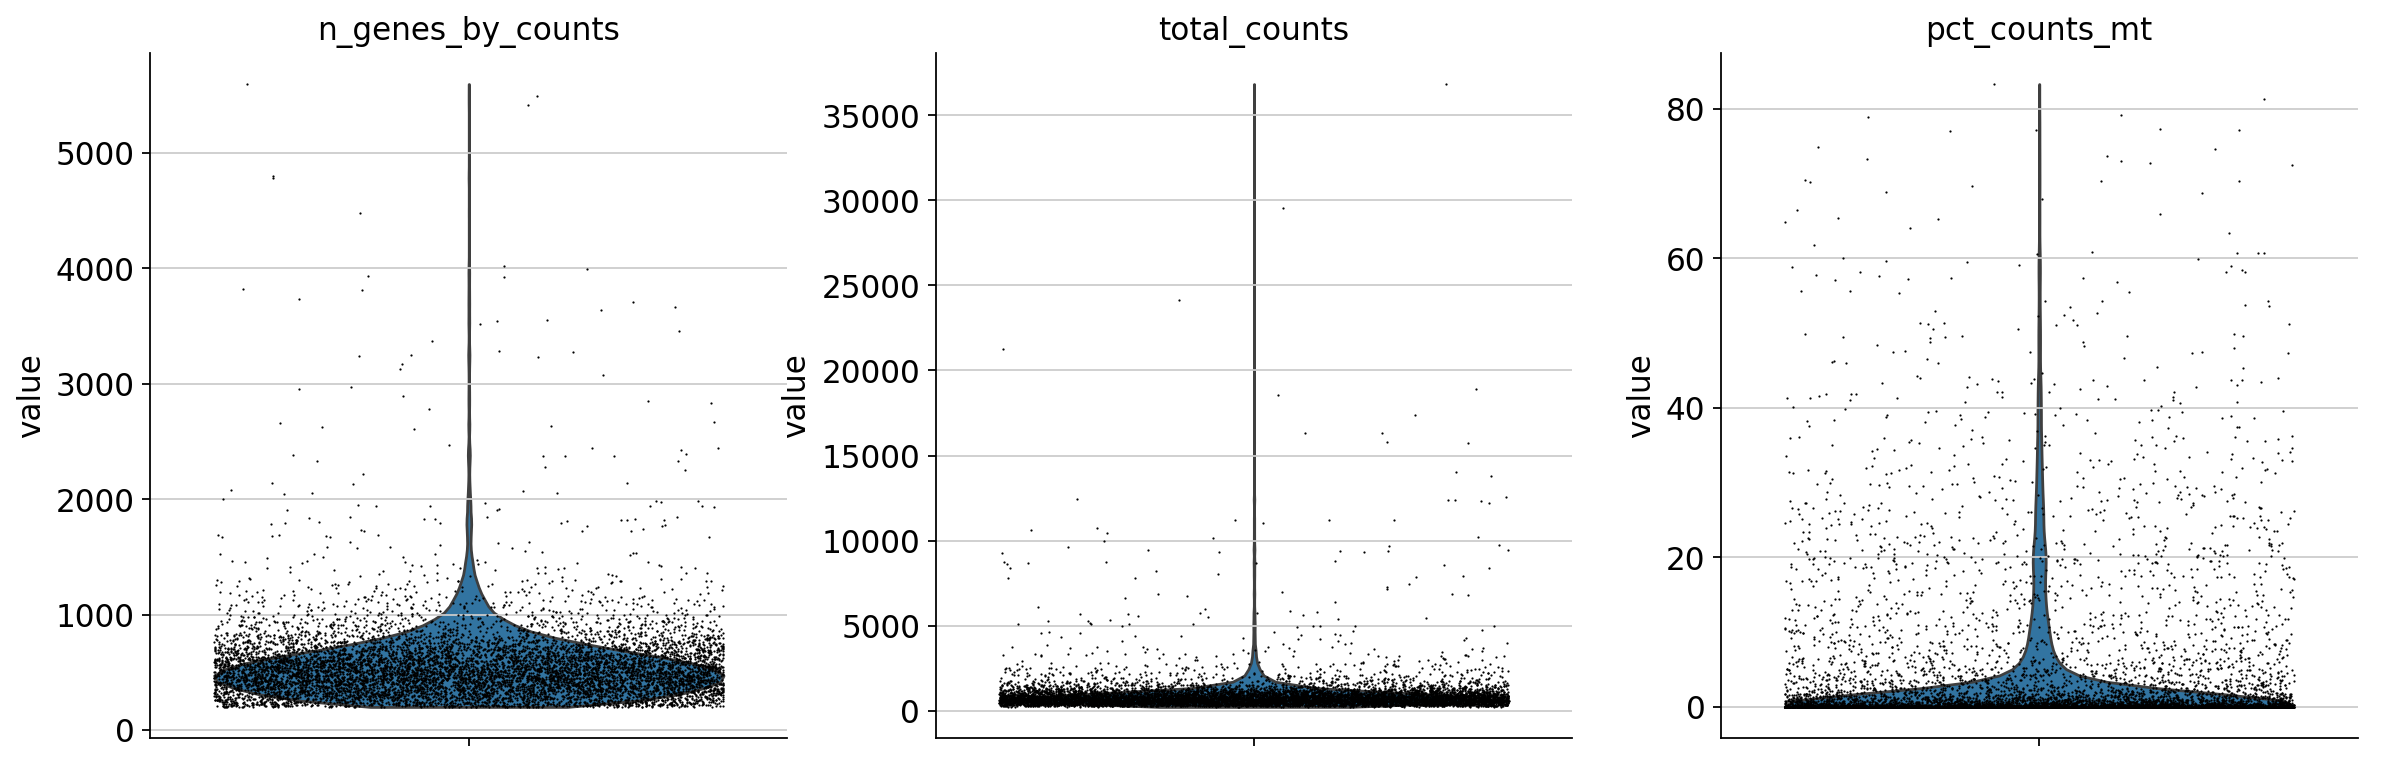

None


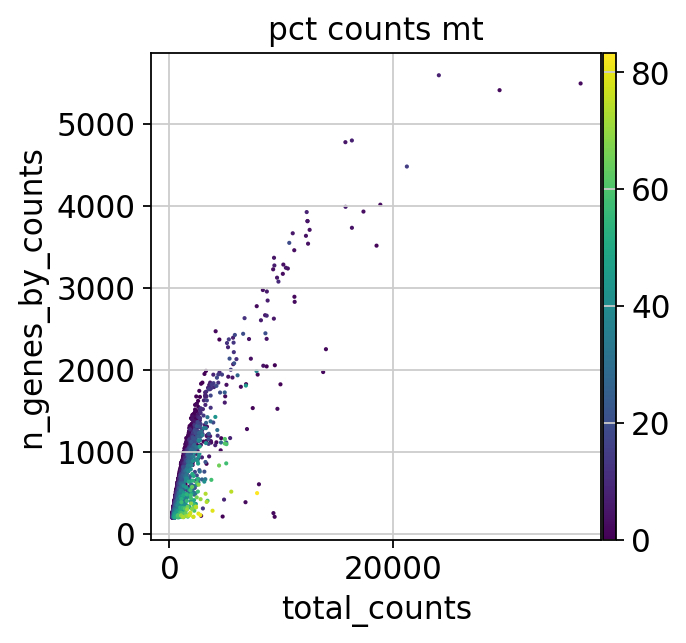

None


[None, None, None, None]

In [62]:
[process_data(adata) for adata in adata_list_nodoub]

In [63]:
adata_list_nodoub

[AnnData object with n_obs × n_vars = 9480 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_cur

In [67]:
df2 = pd.concat([x.obs for x in adata_list_nodoub])
df2 = df2.sort_values('batch')

In [72]:
qc_output_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/results/qc/qc_metrics"

In [73]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 8622 × 28427
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learn

In [74]:
qc_metrics = ['total_counts', 'log1p_total_counts',
              'n_genes', 'n_genes_by_counts', 
              'pct_counts_mt',
              'pct_counts_in_top_20_genes']

In [78]:
def generate_qc_figs(df, value):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(df, row="batch", hue="batch", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')
    
    plt.show()
    return g
    #g.savefig(os.path.join(qc_output_dir, value+'_beforeqc.png'), dpi = 300, bbox_inches = 'tight')

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

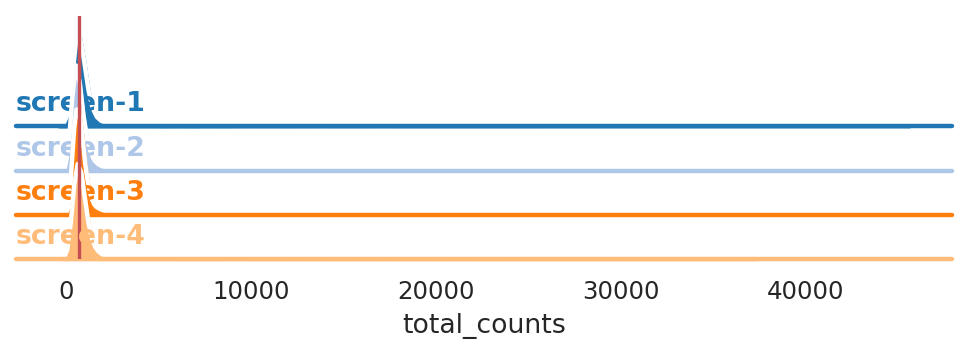

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

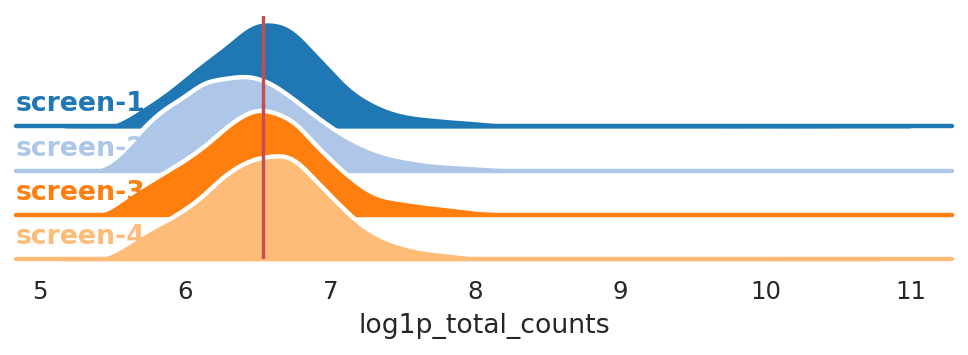

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

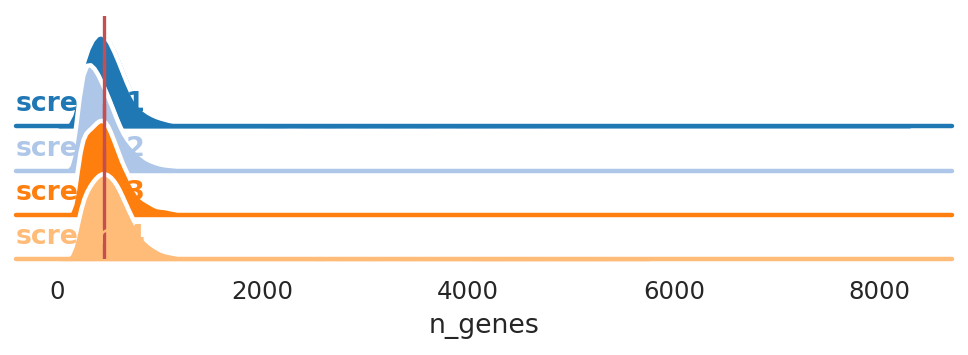

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

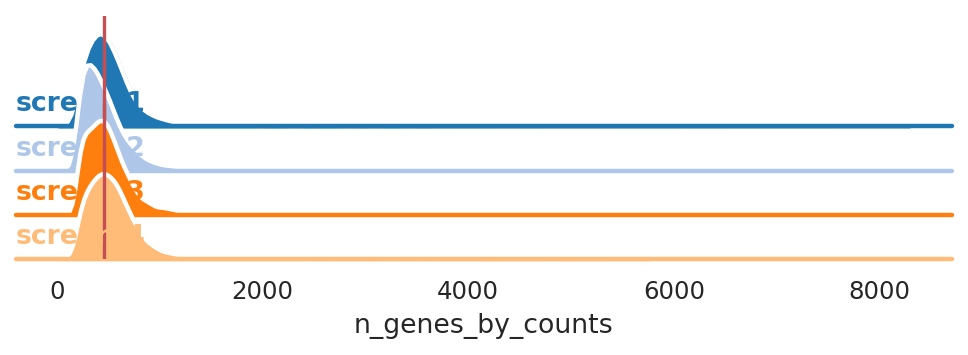

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

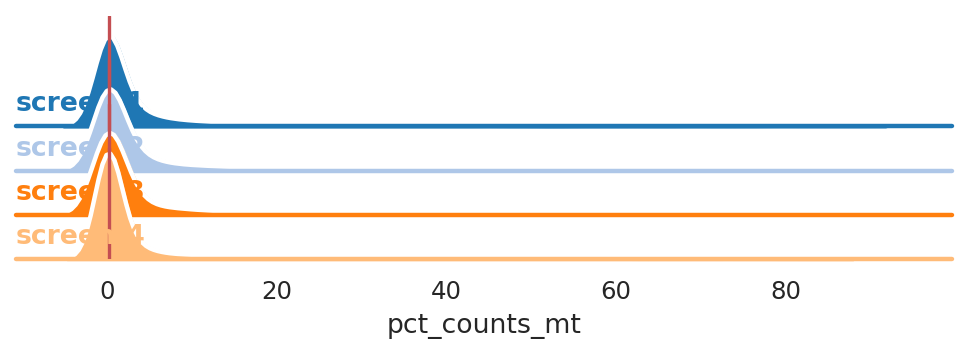

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

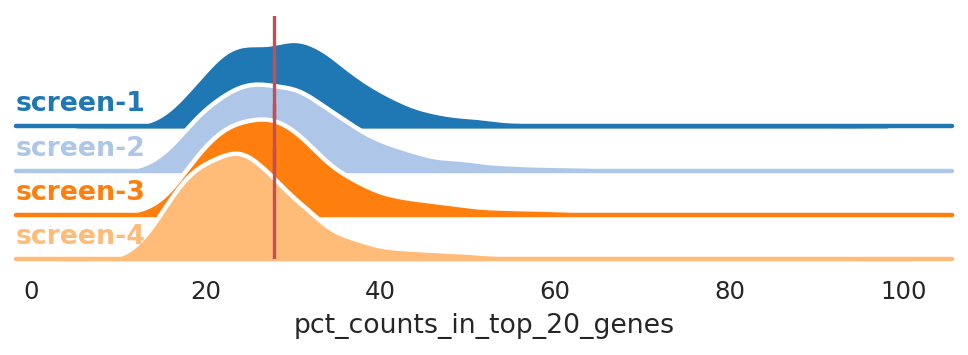

In [77]:
#value = "pct_counts_mt"
#value = "n_genes"
#value = 'pct_counts_in_top_20_genes'
#value = "log1p_total_counts"
for value in qc_metrics:
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(df2, row="batch", hue="batch", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df2[value].median(), color='r', linestyle='-')


    plt.show()
    g.savefig(os.path.join(qc_output_dir, value+'_beforeqc.png'), dpi = 300, bbox_inches = 'tight')

In [84]:
# set initial cutoffs for pct_counts mt at 5, total_counts at 5k, and n_genes by 2500
# for better resolution of figures
pct_counts_mt_cutoff = 5
n_genes_cutoff = 2500
total_counts_cutoff = 5000

In [142]:
adata_list_postqc = []
for adata in adata_list_nodoub:
    adata = adata[adata.obs.n_genes_by_counts < n_genes_cutoff]
    adata = adata[adata.obs.total_counts < total_counts_cutoff]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt_cutoff]
    adata_list_postqc.append(adata)

In [144]:
adata_list_postqc

[View of AnnData object with n_obs × n_vars = 5810 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'lear

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

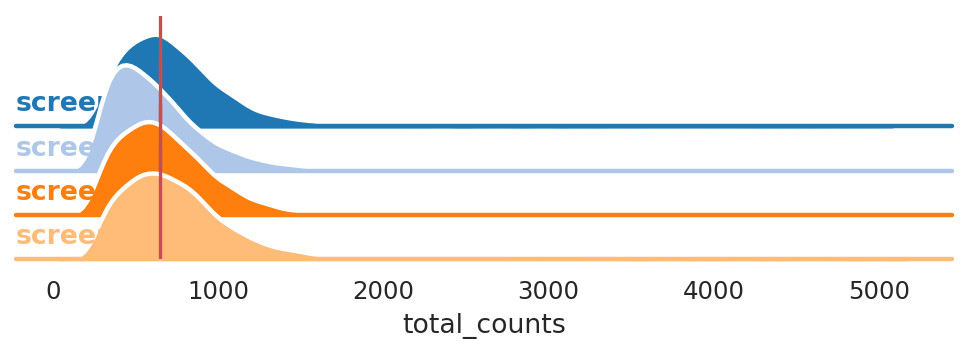

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

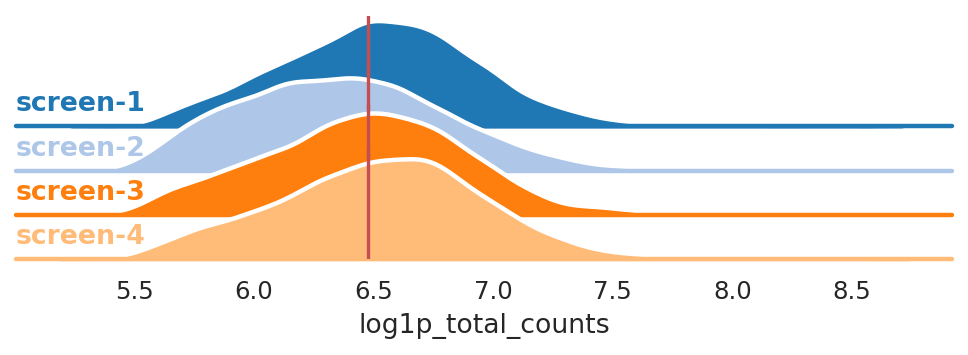

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

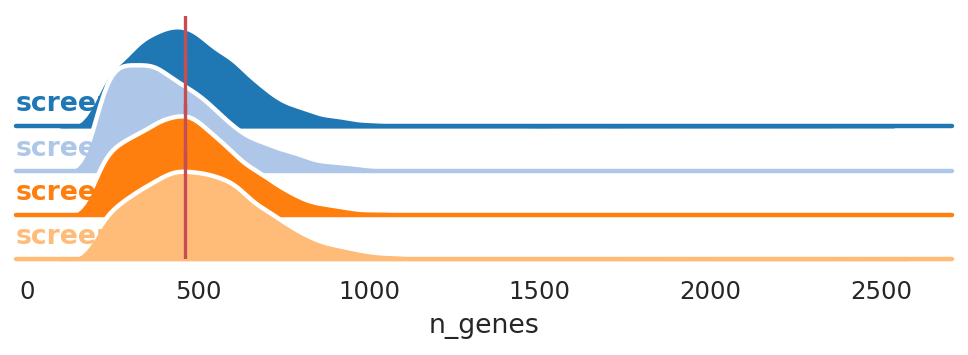

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

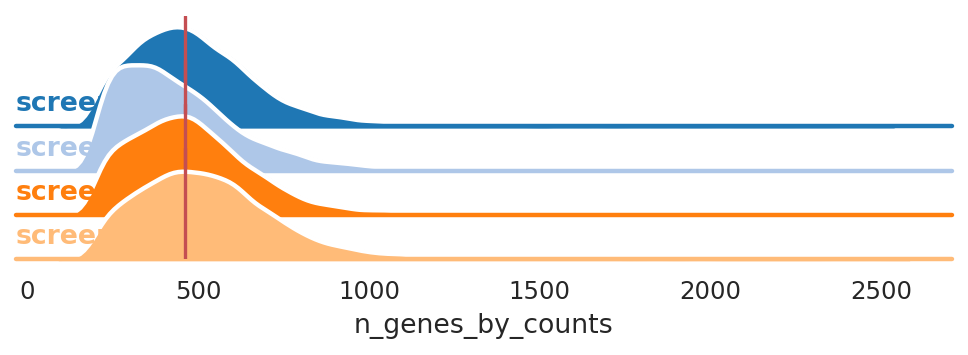

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

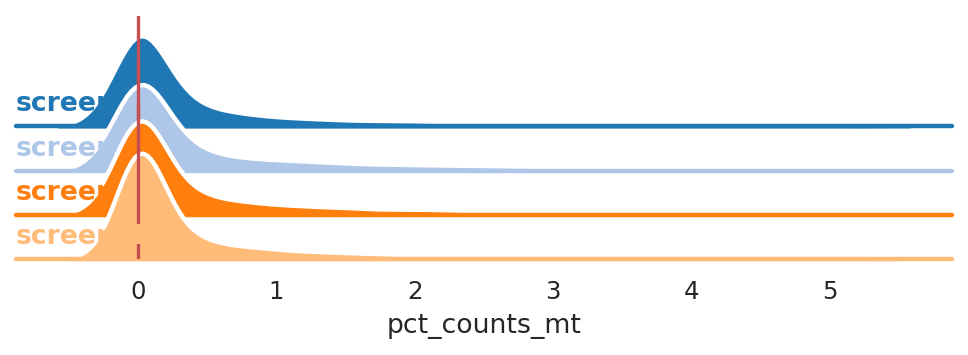

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

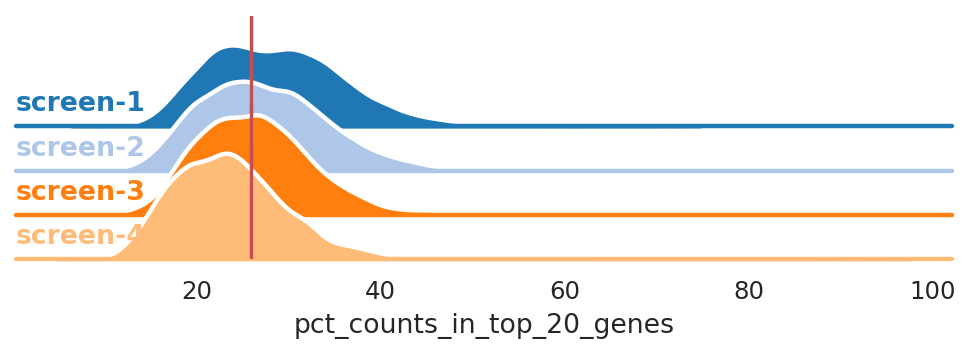

In [90]:
df = pd.concat([x.obs for x in adata_list_postqc])
df = df.sort_values('batch')
for value in qc_metrics:
    g = generate_qc_figs(df, value)
    g.savefig(os.path.join(qc_output_dir, value + '_firstroundqc.png'), dpi = 300, bbox_inches = 'tight')

screen-1...


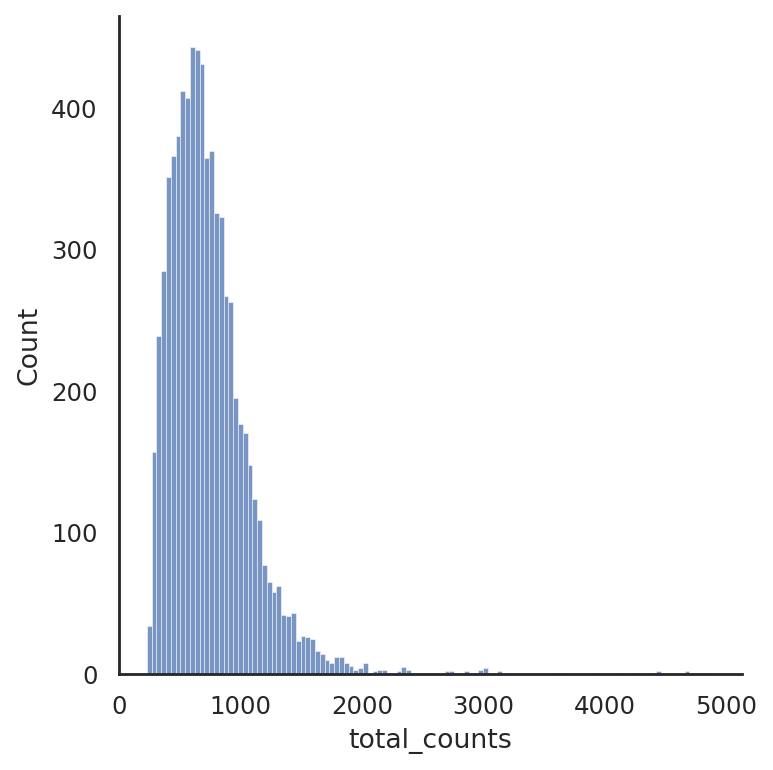

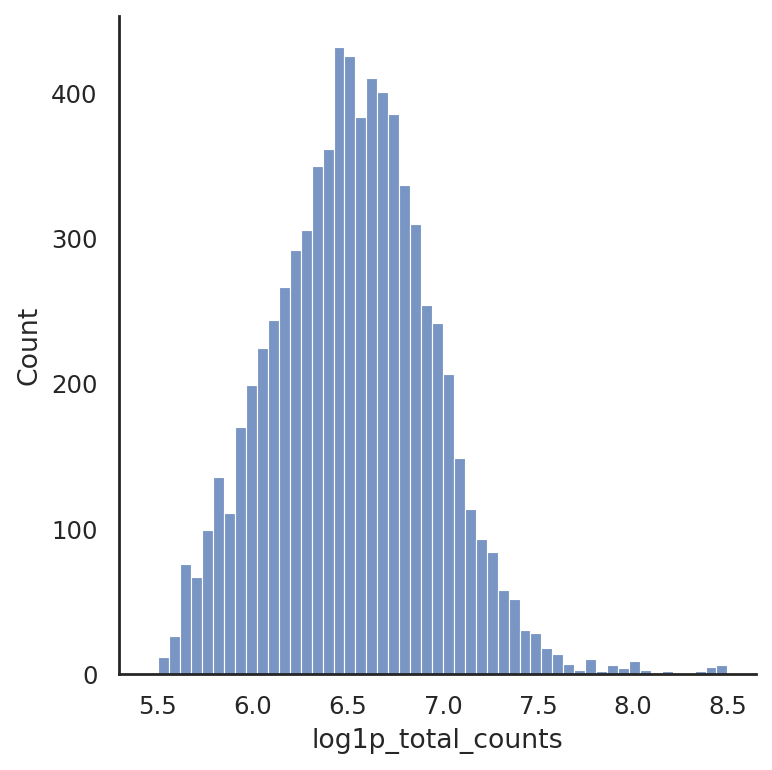

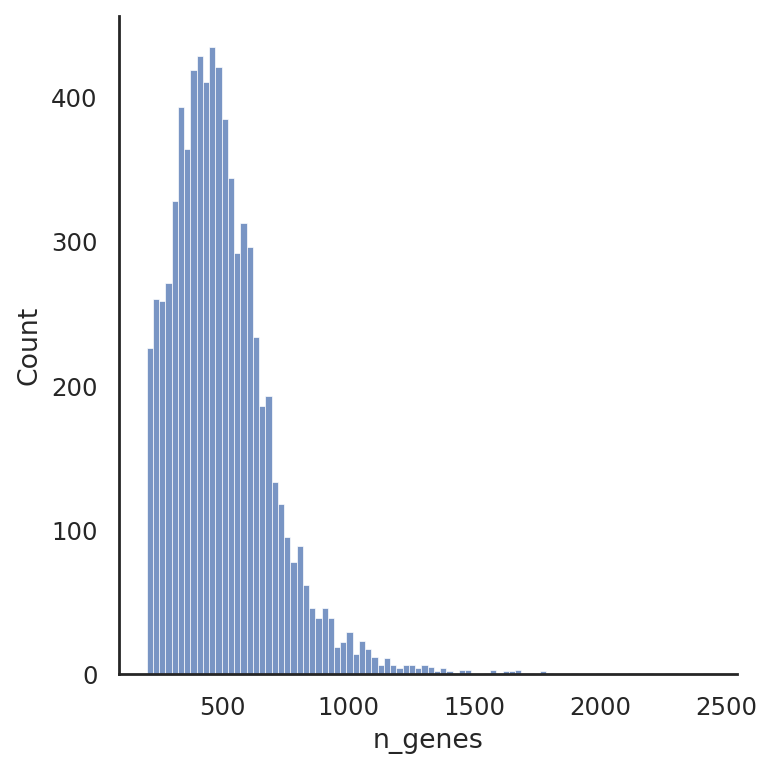

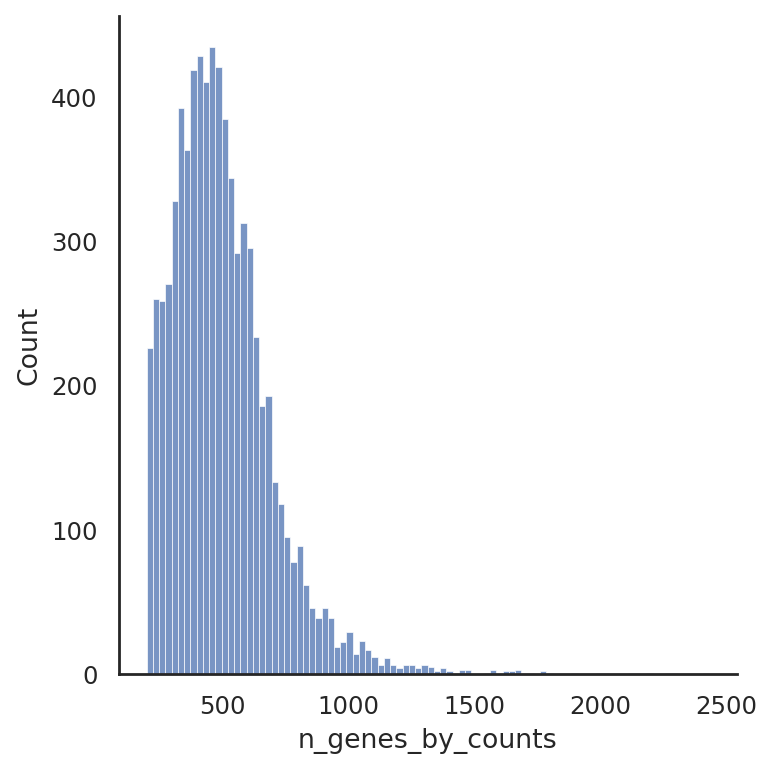

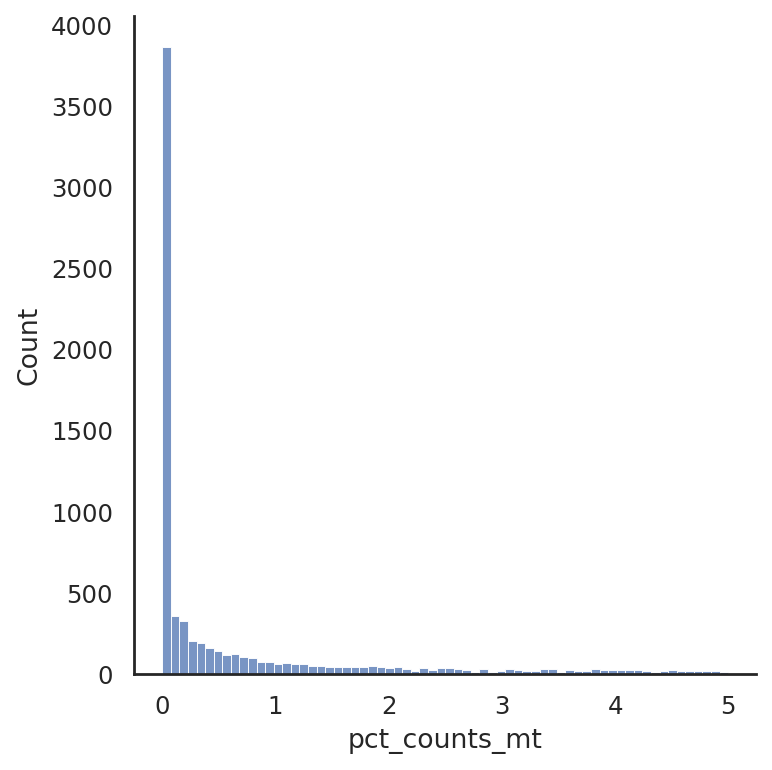

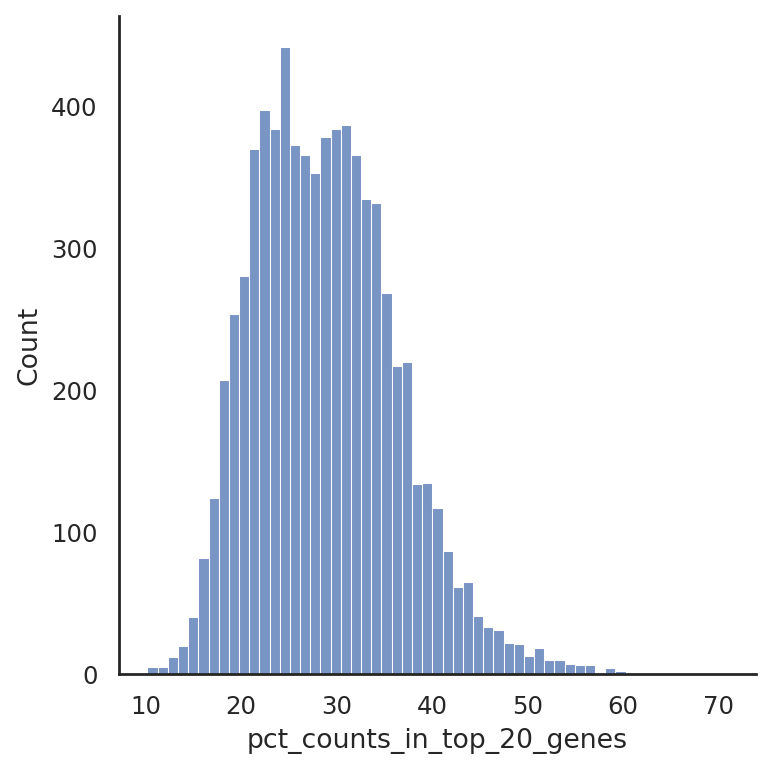

screen-2...


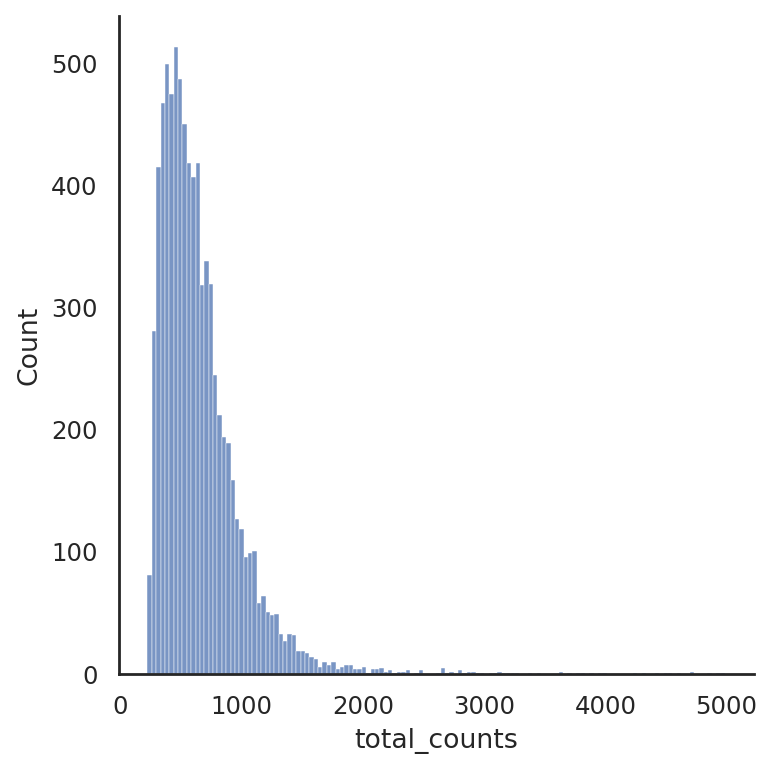

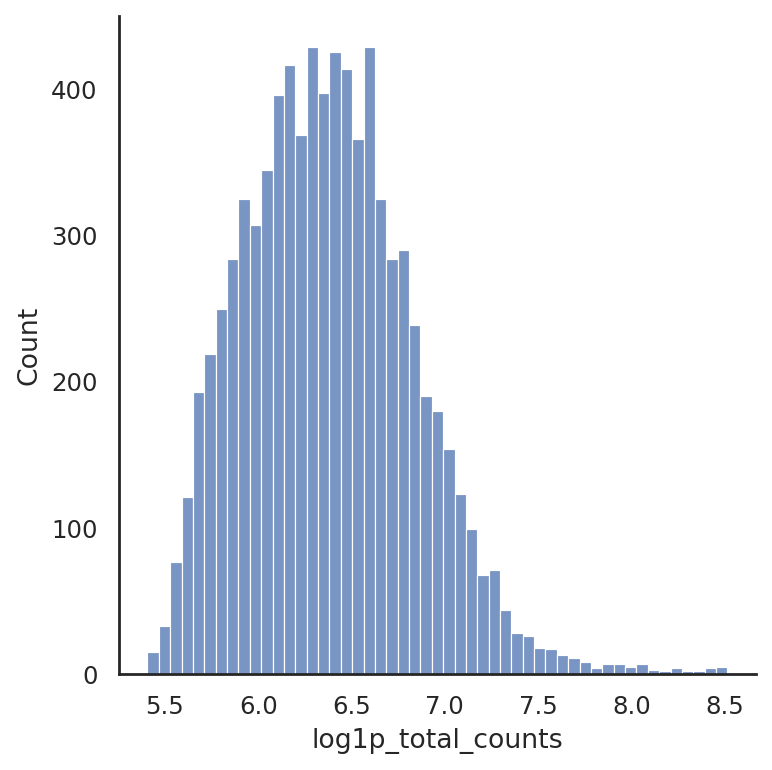

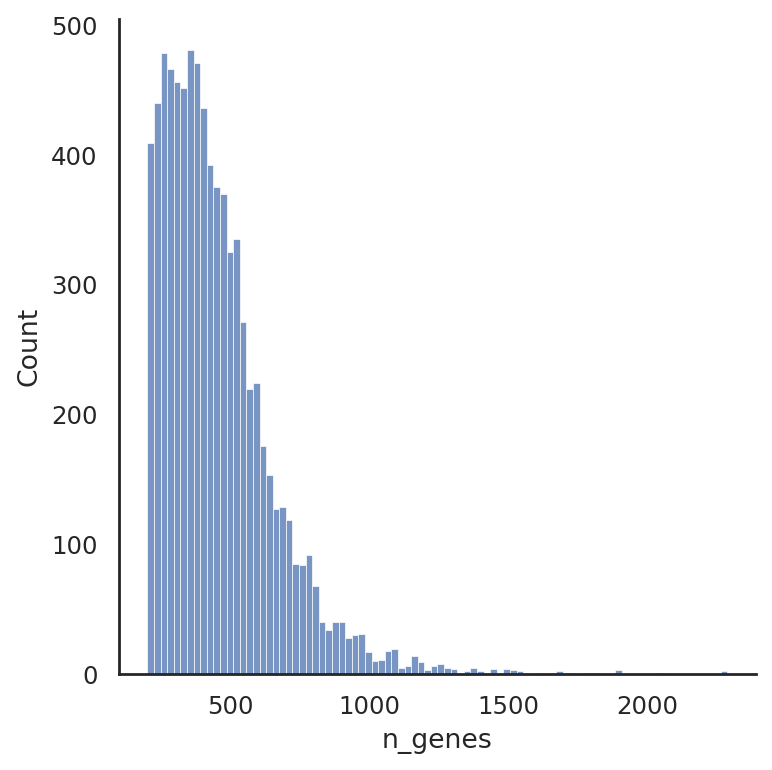

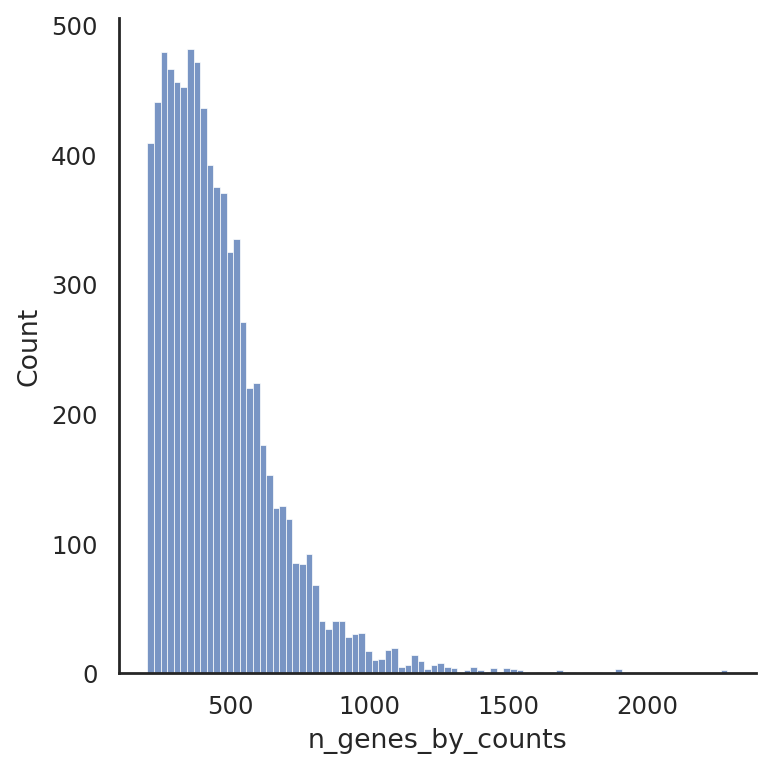

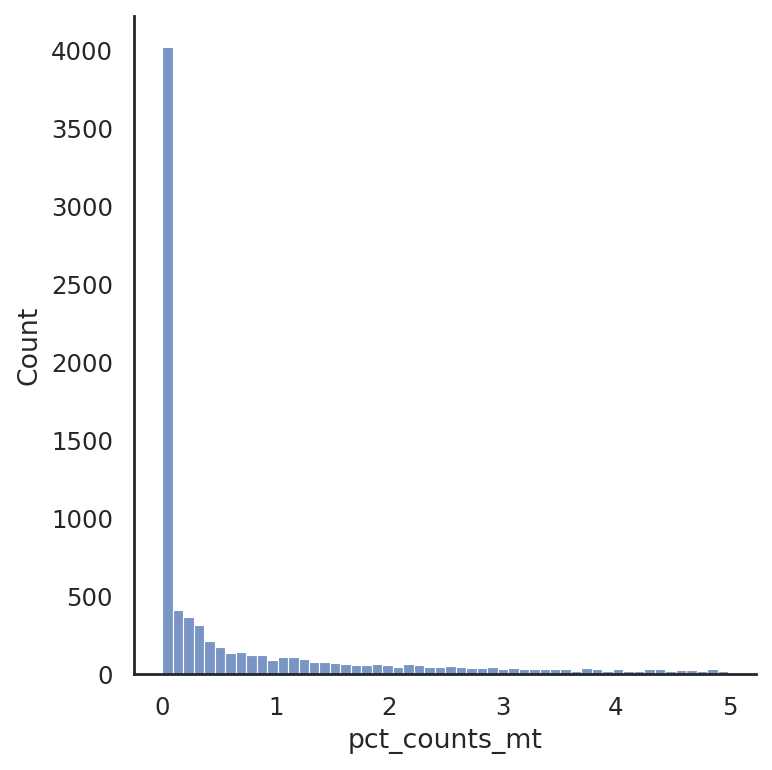

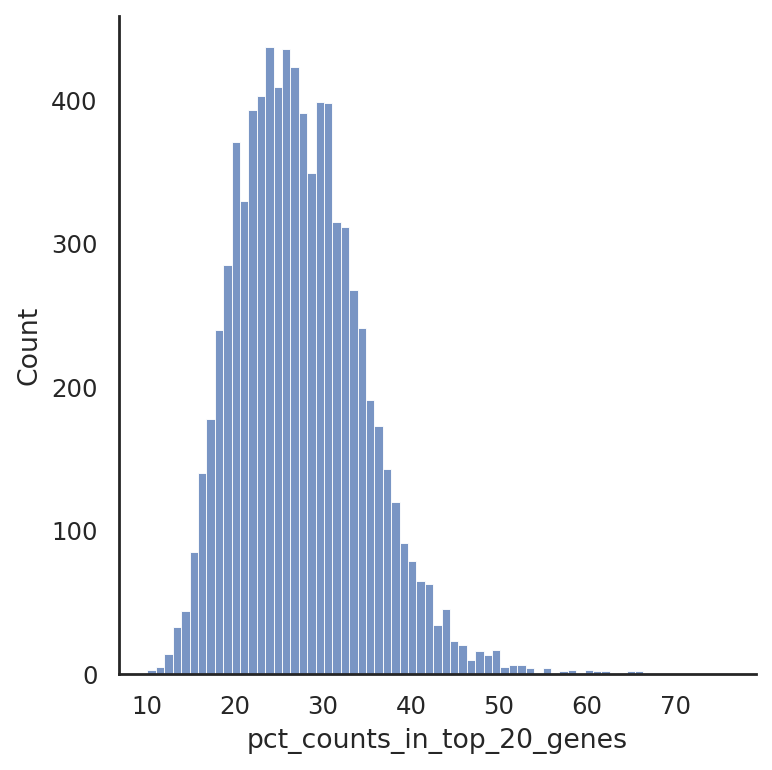

screen-3...


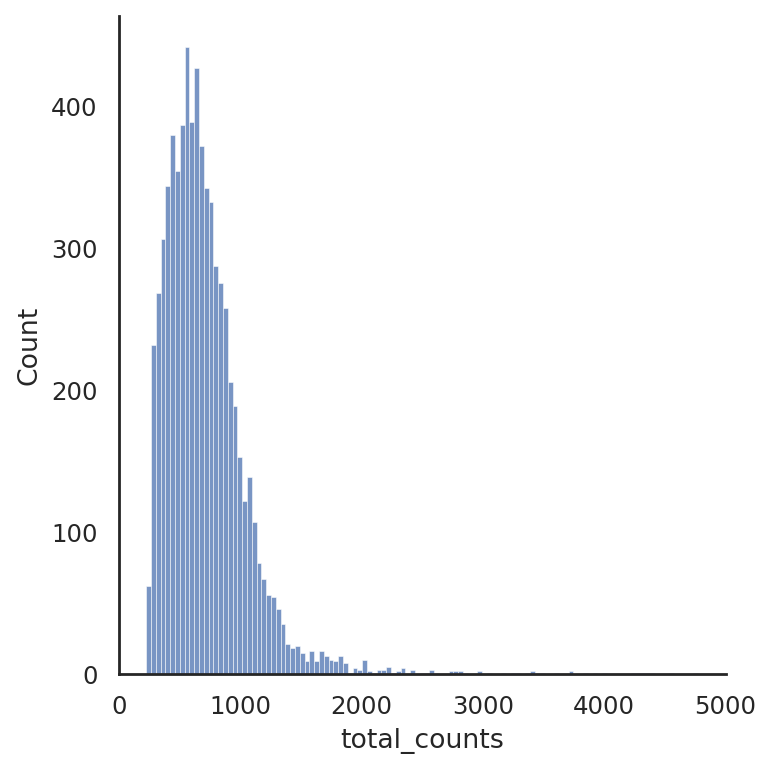

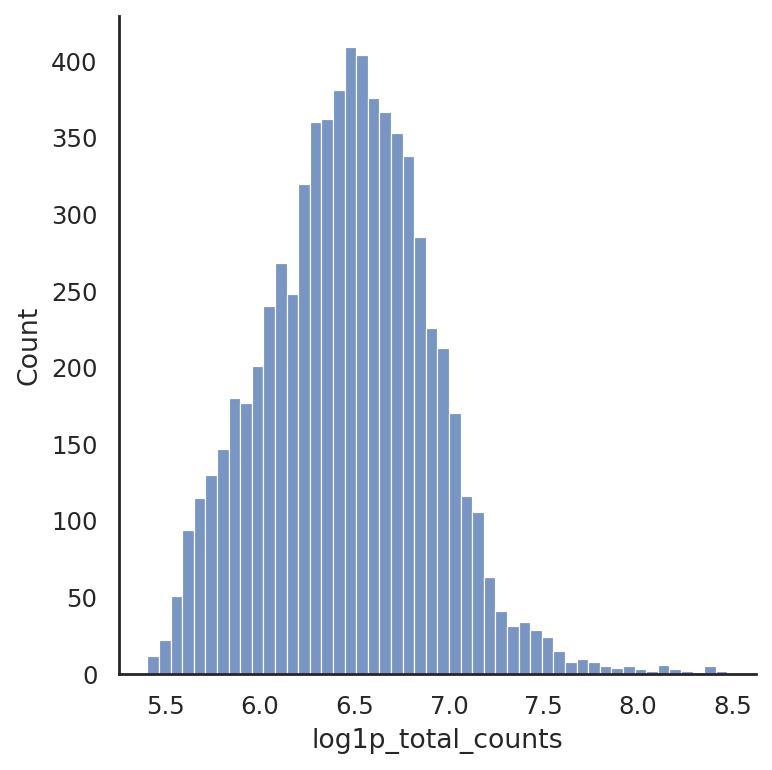

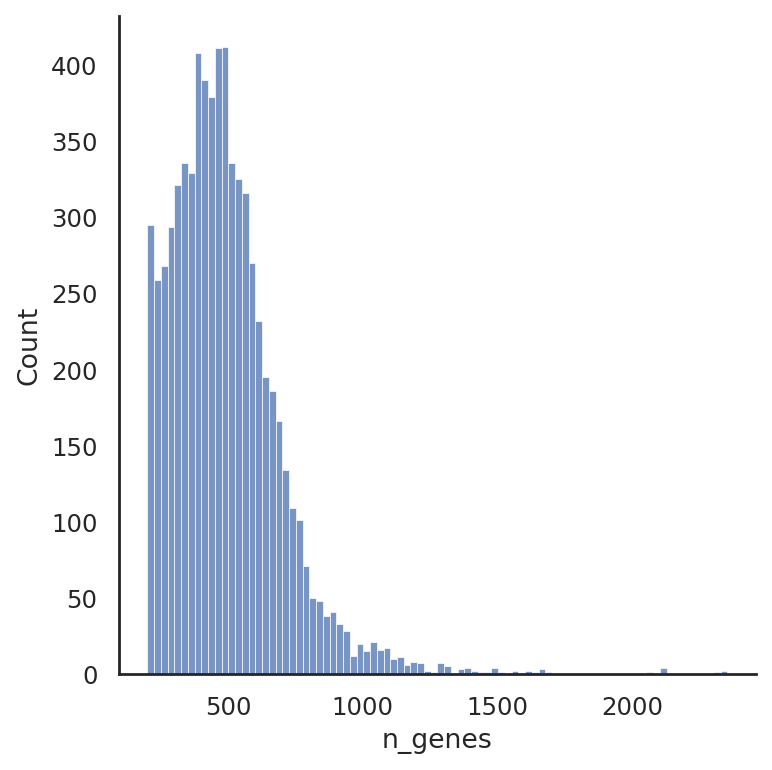

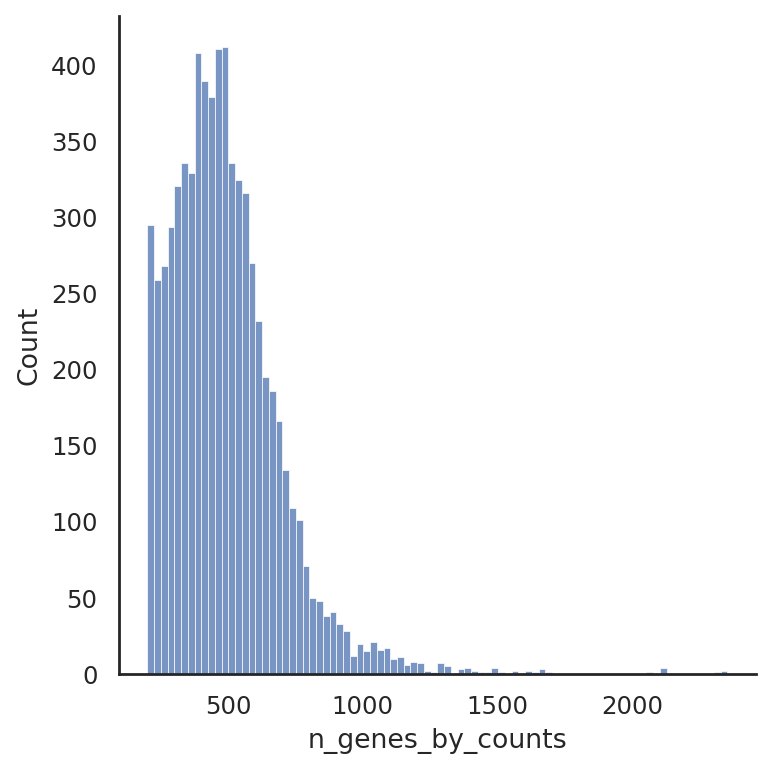

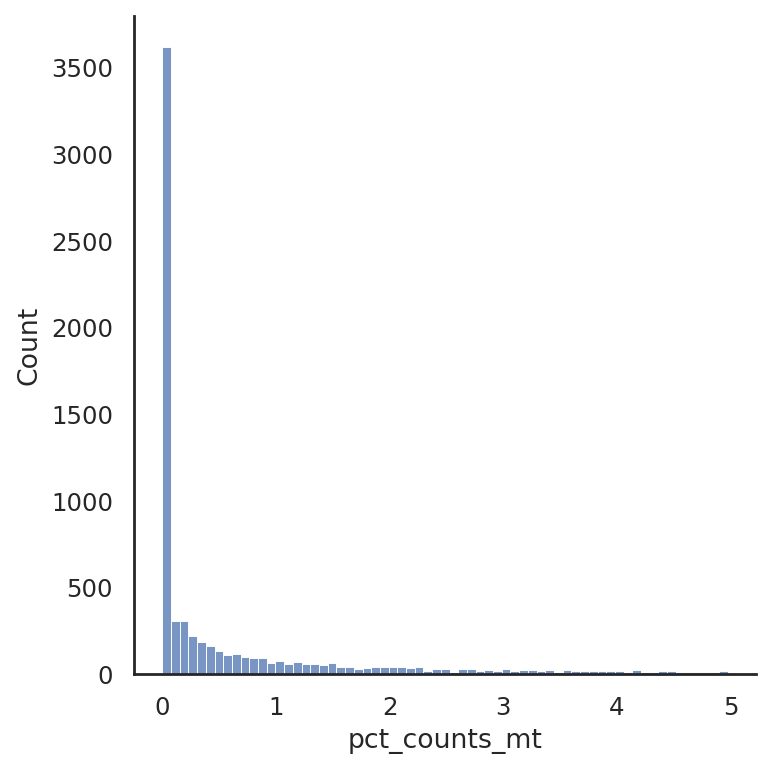

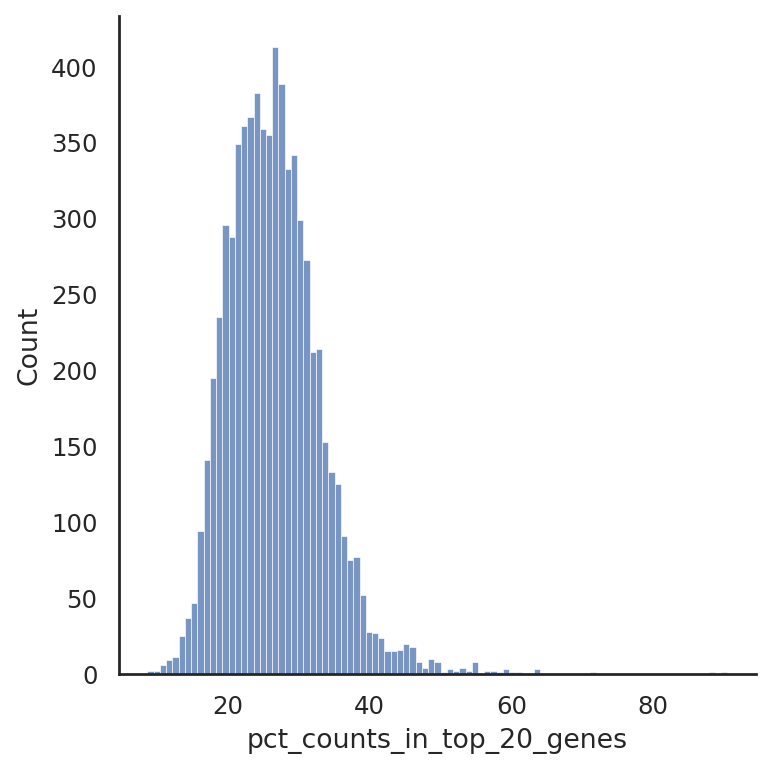

screen-4...


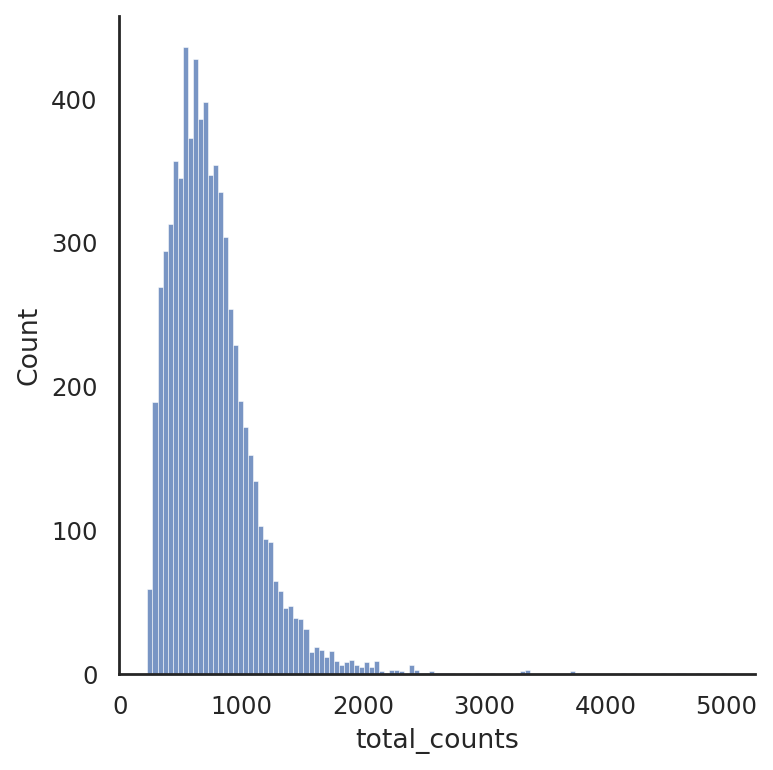

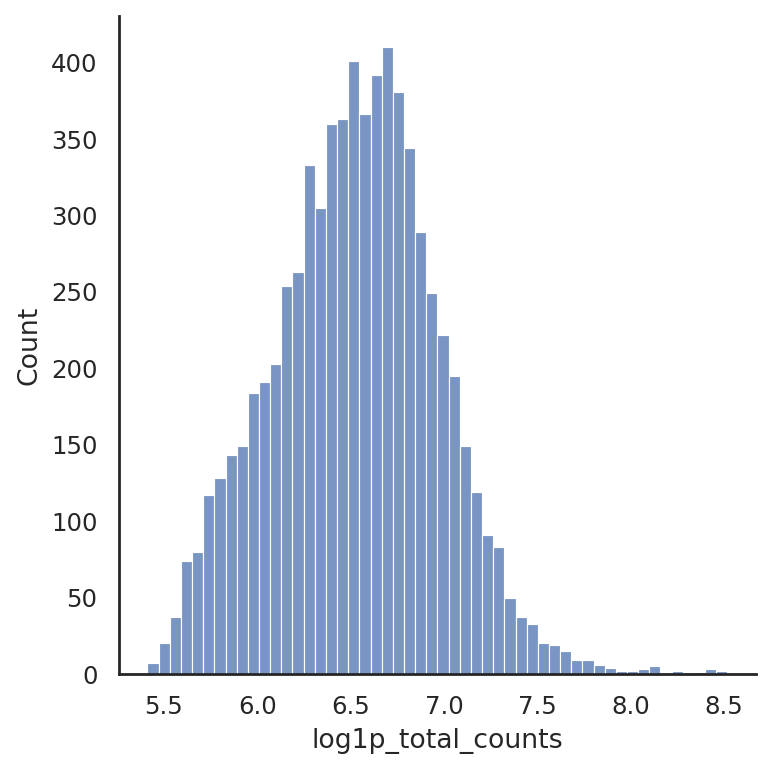

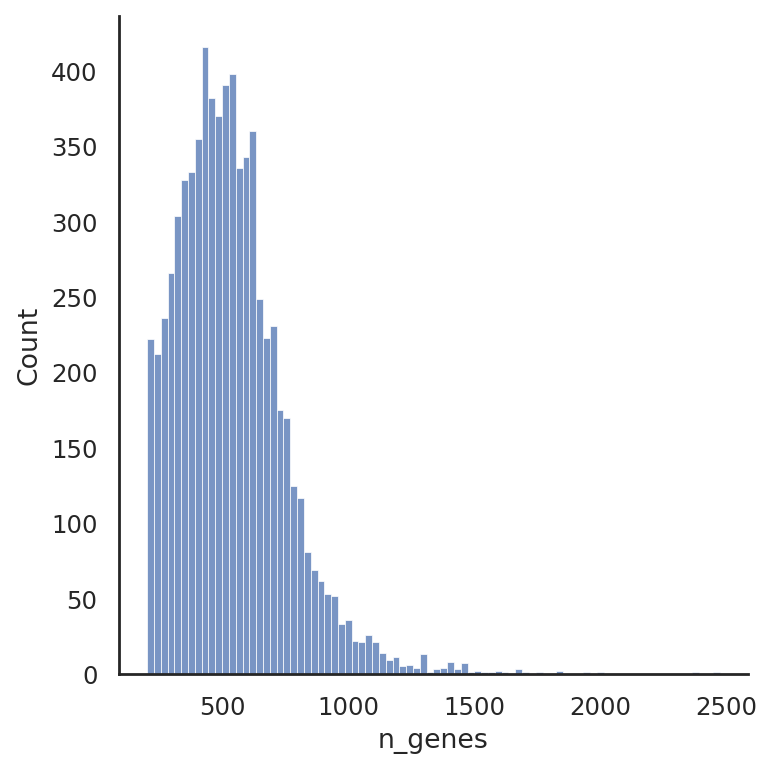

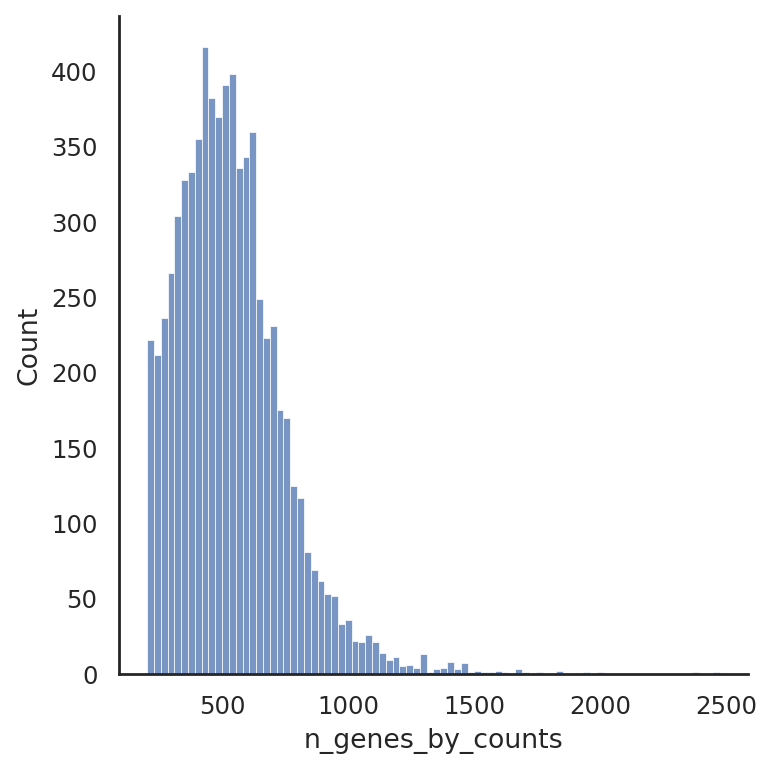

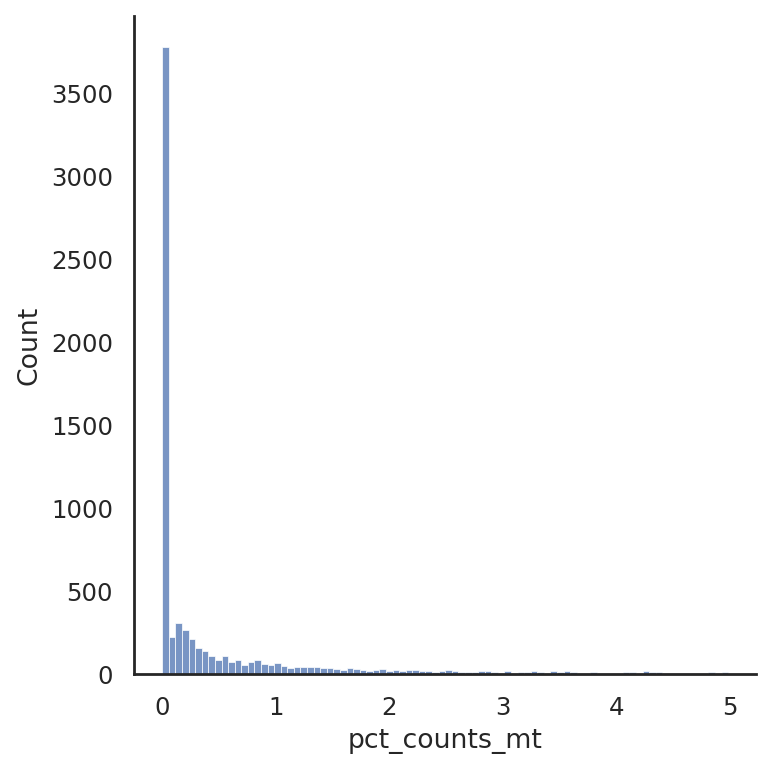

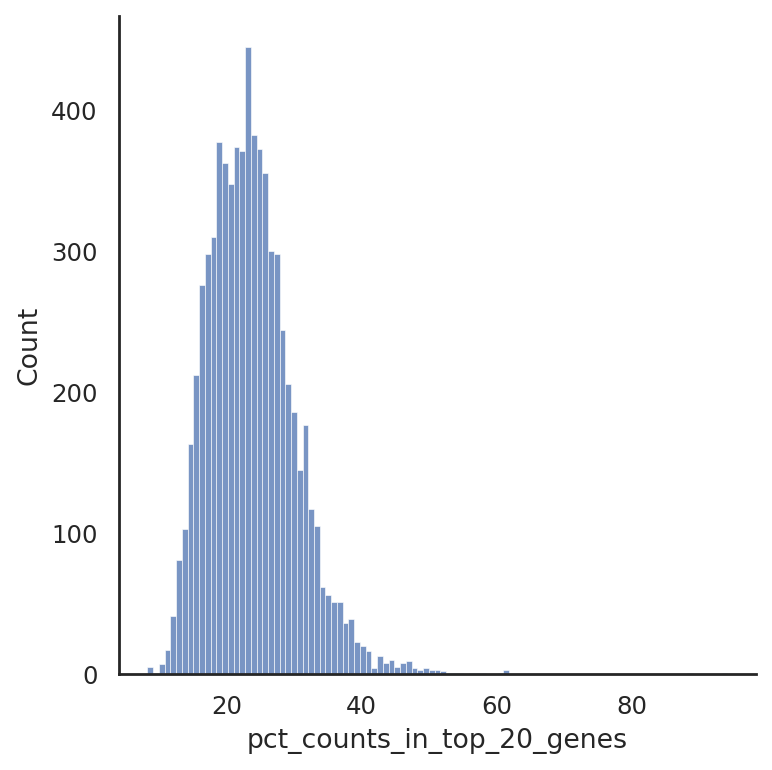

In [96]:
for sample in samples:
    print(sample+'...')
    for value in qc_metrics:
        sns.displot(df[df.batch == sample][value])
        plt.show()

In [133]:
# set the second round cutoffs
n_genes_cutoff = 1500
total_counts_cutoff = 2000
pct_counts_mt_cutoff = 1

In [134]:
for i,adata in enumerate(adata_list_postqc):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_cutoff]
    adata = adata[adata.obs.total_counts < total_counts_cutoff]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt_cutoff]
    print(adata.shape)
    adata_list_postqc[i] = adata

(5810, 28727)
(6065, 28787)
(5480, 28474)
(5828, 28427)


In [145]:
adata_list_postqc

[View of AnnData object with n_obs × n_vars = 5810 × 28727
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'lear

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

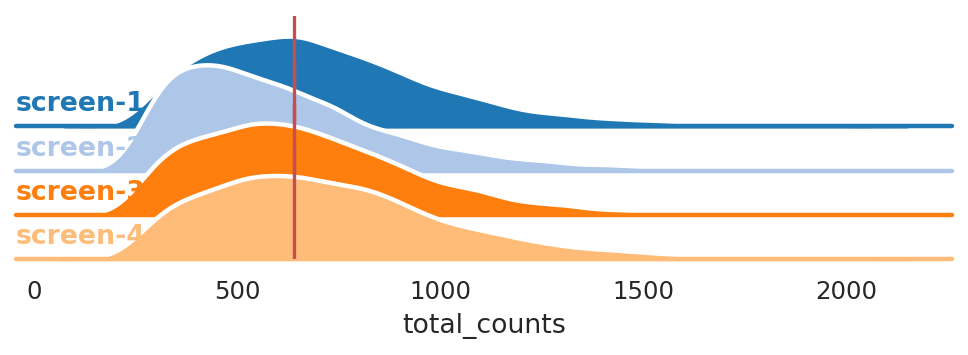

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

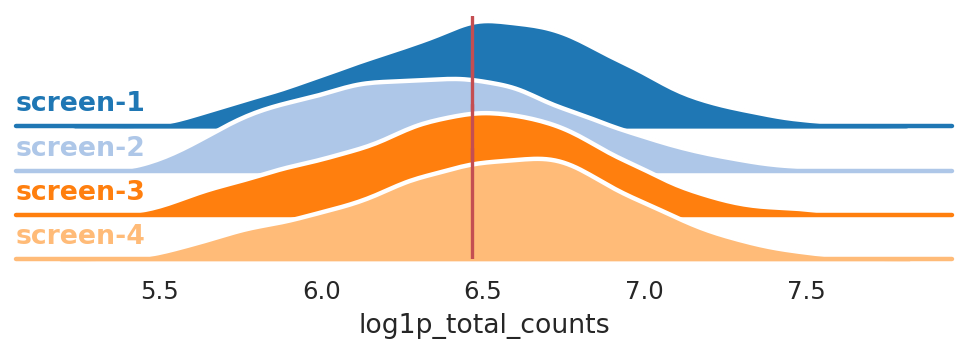

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

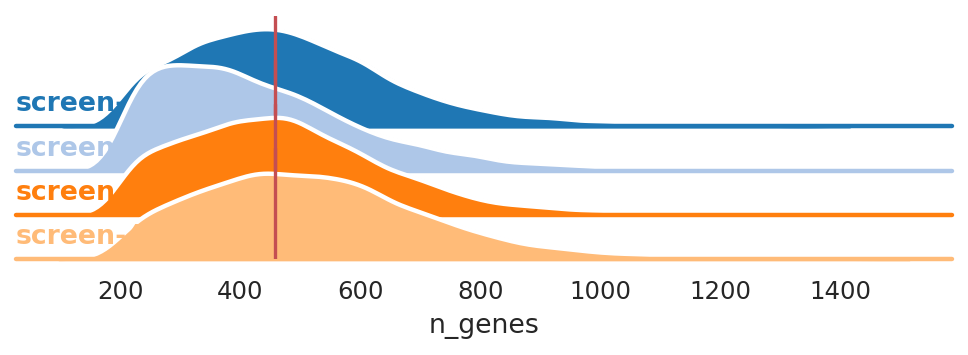

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

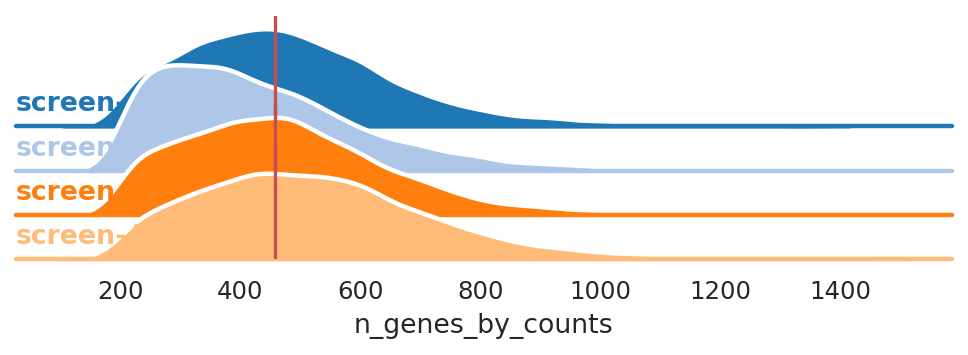

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

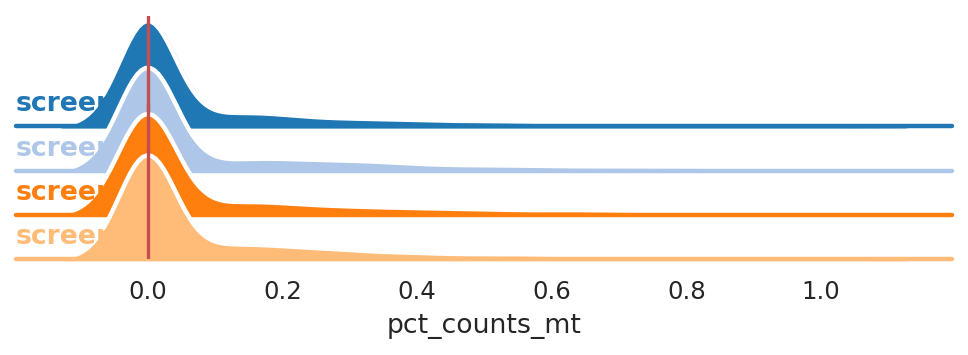

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate

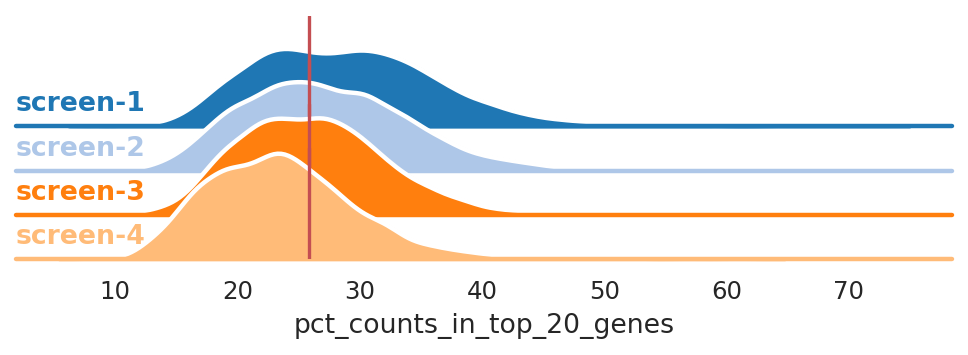

In [146]:
df = pd.concat([x.obs for x in adata_list_postqc])
df = df.sort_values('batch')
for value in qc_metrics:
    g = generate_qc_figs(df, value)
    g.savefig(os.path.join(qc_output_dir, value + '_afterqc.png'), dpi = 300, bbox_inches = 'tight')

In [149]:
output_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/data/velocyto_cellbender_processed/after_qc/indv_samples"

In [148]:
for i,adata in enumerate(adata_list_postqc):
    adata.write(os.path.join(output_dir, samples[i]+"-filtered_combined.h5ad"))

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
